# Large Dataset Training

In [ ]:
import os
import json
from stelaro.data import format, ncbi, synthetic

DATA_DIRECTORY = "../data/"
SUMMARY_DIRECTORY = DATA_DIRECTORY + "ncbi_genome_summaries/"
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
DATASET_V1_DIRECTORY = DATA_DIRECTORY + "version_1/"
DATASET_V1_COMPRESSED_DIRECTORY = DATASET_V1_DIRECTORY + "compressed/"


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)


mkdir(DATA_DIRECTORY)
mkdir(DATASET_V1_DIRECTORY)
mkdir(DATASET_V1_COMPRESSED_DIRECTORY)

## 1. Compress The Dataset

In [3]:
LENGTH = 1500
with open("../datasets/version_1_splits/map.json", "r") as f:
    index_to_taxonomic_label = json.load(f)

for dataset_name in ("validate", "test", "train"):
    with open(f"../datasets/version_1_splits/{dataset_name}.json", "r") as f:
        dataset = json.load(f)
    index_to_n_passes = {}
    directory = DATASET_V1_COMPRESSED_DIRECTORY + dataset_name + "/"
    mkdir(directory)
    synthetic.compress_dataset(
        dataset,
        index_to_taxonomic_label,
        "../data/version_1/genomes/",
        LENGTH,
        directory
    )

100%|██████████| 27/27 [41:05<00:00, 91.32s/it] 


## 2. Sample Data

In [2]:
f = synthetic.get_n_reads_in_compressed_dataset(
    DATASET_V1_COMPRESSED_DIRECTORY + "test/",
)
print(f)
n = sum(f)
ids = synthetic.get_random_identifiers(n)

[ 12643  22777  34943  31102  60816   4144  64119  86229   5006  25801
   5386   8599  29738  22694  37733  15253  58687 118124  85929 137871
  79875 149174  21096  75607  16687   1920    346]


In [3]:
from numpy import bincount
x, y = synthetic.sample_compressed_dataset(
    DATASET_V1_COMPRESSED_DIRECTORY + "test/",
    200_000,
    1500,
    ids,
    400000
)
print(bincount(y))
print(sum(bincount(y)))

[ 2091  3754  5830  5052 10021   647 10467 14440   800  4357   888  1434
  4802  3723  6316  2519  9638 19468 14160 22791 13193 24595  3484 12415
  2733   330    52]
200000


In [ ]:
import numpy as np
from random import shuffle


def get_floored_random_identifiers(directory: str, floor: int, n: int) -> dict:
    """Same as `get_random_identifiers`, but generates identifiers that
    include all elements of a class if its count is low.
    """
    assert floor > 1, "Invalid floor."
    # Determine the number of samples for each class.
    total_reads = synthetic.get_n_reads_in_compressed_dataset(directory)
    counts_to_fetch = {}
    for i, n_reads in enumerate(total_reads):
        if n_reads < floor:
            counts_to_fetch[i] = int(n_reads)
        else:
            counts_to_fetch[i] = 0
    n_remaining = n - sum(counts_to_fetch.values())
    n_remaining_classes = len([0 for _, v in counts_to_fetch.items() if v == 0])
    average = n_remaining / n_remaining_classes
    for i, n_reads in enumerate(total_reads):
        if counts_to_fetch[i] == 0:
            counts_to_fetch[i] = int(average)
            if average > n_reads:
                raise RuntimeError(f"Insufficient number of reads. Required: {average}. Available: {n_reads}.")
    # Obtain sample indices.
    assert directory.endswith("/")
    with open(directory + "counts.json", "r") as file:
        counts = json.load(file)
    identifiers = {k: [] for k in counts_to_fetch}
    global_index = 0
    for identifier, count in counts.items():
        partial_y = np.load(directory + str(identifier) + "_y.npy")
        partial_y = partial_y[:count]
        for i in range(len(partial_y)):
            identifiers[partial_y[i]].append(global_index)
            global_index += 1
    # Reduce the number of samples.
    indices = []
    for i in range(len(identifiers)):
        shuffle(identifiers[i])
        indices += identifiers[i][:counts_to_fetch[i]]
    shuffle(indices)
    identifiers = {}
    for i, v in enumerate(indices):
        identifiers[i] = v
    return identifiers


indices = get_floored_random_identifiers(
    DATASET_V1_COMPRESSED_DIRECTORY + "test/",
    1000,
    50_000
)

{0: 1069153, 1: 342594, 2: 1109940, 3: 1199448, 4: 3540, 5: 1111912, 6: 417384, 7: 690975, 8: 491436, 9: 355662}


In [14]:
with open(f"../datasets/version_1_splits/train.json", "r") as f:
    dataset = json.load(f)


taxon = dataset[-1]
print(taxon[0])
references = []
for element in taxon[1]:
    genus, ref = element
    references += ref
print(synthetic.evaluate_n_nucleotides(references))


['Viruses', 'Monodnaviria']
5158834


In [7]:
import numpy as np
x = np.load(DATASET_V1_COMPRESSED_DIRECTORY + "train/0_x.npy")
print(x.shape)

(1000000, 375)


## 3. Train Neural Networks

In [3]:
from stelaro import models
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from stelaro.models import feedforward, autoencoder, transformer, hybrid
from time import time

LENGTH = 1500
BATCH_SIZE = 128
N_SAMPLE_BETWEEN_INTERVALS = 50_000

train_data = DataLoader(
    synthetic.CompressedReadDataset(
        "../data/version_1/compressed/train/", N_SAMPLE_BETWEEN_INTERVALS, 10
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)
validate_data = DataLoader(
    synthetic.SyntheticReadDataset(
        "../data/version_1/compressed/validate/", 50_000, LENGTH, 2000
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_data = DataLoader(
    synthetic.SyntheticReadDataset(
        "../data/version_1/compressed/test/", 100_000, LENGTH, 2000
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

with open("../datasets/version_1_splits/map.json", "r") as f:
    mapping = json.load(f)


def benchmark(classifier: models.BaseClassifier, name: str, n_max_reads, patience=4):
    train_data.dataset.reset()
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=0.001)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1, v_losses = classifier.train_large_dataset(
        train_data,
        validate_data,
        optimizer,
        evaluation_interval=N_SAMPLE_BETWEEN_INTERVALS,
        n_max_reads=n_max_reads,
        patience=patience,
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="Training Losses")
        ax[0].plot(x[1:], v_losses, label="Validation Losses")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Loss")
        ax[0].legend()
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping, permute=False)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test results: {rounded_result}")
    return classifier


from torch import no_grad, float32
import numpy as np


def confusion_matrix(classifier, loader, device, mapping) -> np.ndarray:
    """Returns: A confusion matrix with rows corresponding to true labels."""
    matrix = np.zeros((len(mapping), len(mapping)))
    with no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.type(float32).to(device)
            #x_batch = x_batch.permute(0, 2, 1)  # Swap channels and sequence.
            y_batch = y_batch.to("cpu")
            predictions = classifier.predict(x_batch)
            for y, p in zip(y_batch, predictions):
                matrix[y][p] += 1
    return matrix

KeyboardInterrupt: 

### 3.1. Baseline

In [3]:
model = benchmark(
    models.RandomClassifier(),
    "Random Classifier",
    n_max_reads=30_000
)
model.n_classes = len(mapping)

  0%|          | 234/68609 [00:01<06:59, 163.08it/s]


Training took 1.447 s.
Test results: [0.33168, 0.032433]


d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classe

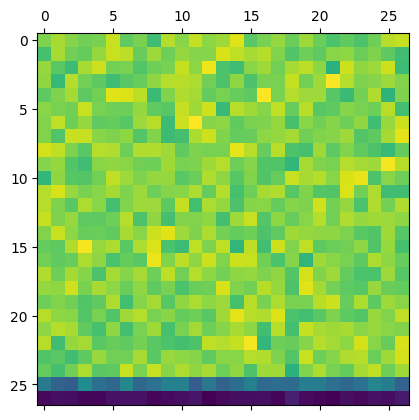

In [4]:
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()

In [5]:
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)
print(np.sum(matrix))
print(np.sum(matrix, axis=0))
print(np.sum(matrix, axis=1))

[[143. 154. 145. 140. 142. 162. 135. 142. 124. 157. 146. 161. 147. 151. 168. 133. 142. 149. 138. 151. 138. 128. 135. 129. 139. 158. 161.]
 [127. 154. 140. 136. 149. 162. 159. 137. 151. 139. 149. 145. 145. 166. 160. 154. 157. 144. 130. 139. 134. 146. 147. 138. 143. 134. 124.]
 [149. 133. 123. 154. 163. 141. 142. 131. 139. 142. 161. 147. 172. 128. 124. 146. 151. 140. 154. 159. 147. 115. 163. 148. 151. 163. 123.]
 [148. 120. 157. 141. 134. 124. 133. 137. 148. 157. 158. 155. 140. 129. 147. 129. 142. 142. 161. 140. 152. 175. 157. 143. 145. 151. 144.]
 [134. 143. 153. 134. 140. 168. 167. 159. 122. 144. 156. 153. 136. 142. 137. 134. 175. 142. 157. 151. 151. 132. 122. 141. 156. 117. 143.]
 [146. 142. 140. 162. 142. 139. 139. 149. 135. 132. 161. 152. 164. 121. 158. 152. 145. 160. 137. 158. 132. 134. 145. 142. 139. 158. 125.]
 [144. 160. 139. 149. 135. 136. 132. 151. 158. 123. 163. 176. 145. 147. 135. 142. 143. 149. 127. 146. 140. 145. 139. 148. 124. 150. 163.]
 [144. 130. 162. 162. 146. 143. 14

### 3.2. CNN

Number of parameters: 35_967_670


  1%|          | 388/68609 [00:19<35:23, 32.13it/s]  

N Reads: 50_048 Loss: 8.30. F1: [0.34981, 0.047944]. Patience: 2


  1%|          | 780/68609 [00:40<35:33, 31.79it/s]   

N Reads: 100_096 Loss: 7.84. F1: [0.397, 0.092939]. Patience: 2


  2%|▏         | 1172/68609 [01:05<2:48:09,  6.68it/s]

N Reads: 150_144 Loss: 7.10. F1: [0.47374, 0.16145]. Patience: 2


  2%|▏         | 1563/68609 [01:28<2:46:29,  6.71it/s] 

N Reads: 200_192 Loss: 6.37. F1: [0.54247, 0.14903]. Patience: 1


  3%|▎         | 1954/68609 [01:52<2:52:12,  6.45it/s] 

N Reads: 250_240 Loss: 6.08. F1: [0.53294, 0.20253]. Patience: 1


  3%|▎         | 2344/68609 [02:16<2:51:14,  6.45it/s] 

N Reads: 300_288 Loss: 5.84. F1: [0.57287, 0.17676]. Patience: 0


  3%|▎         | 2345/68609 [02:25<1:08:37, 16.10it/s]

The model is overfitting; stopping early.
Processed 300_288 reads.
Training took 145.705 s.


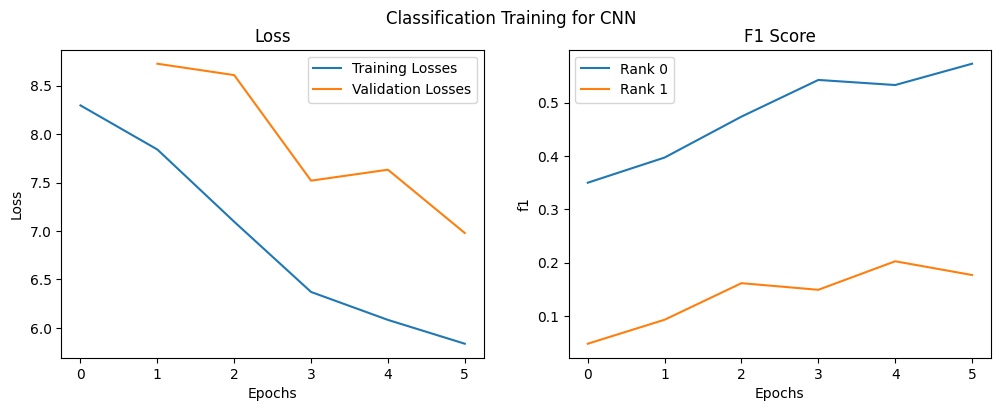

Test results: [0.53675, 0.21979]


In [ ]:
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d)
from torch import stack, tensor, float32
from torch.func import vmap
import torch.nn.functional as F


class CNN_2_dropout_token(Module):
    def __init__(self, N, M):
        super(CNN_2_dropout_token, self).__init__()
        self.conv = Sequential(
            Conv1d(4, 32, kernel_size=7, padding=3),
            ReLU(),
            Conv1d(32, 64, kernel_size=5, padding=2),
            ReLU(),
            Conv1d(64, 128, kernel_size=3, padding=1),
            ReLU(),
        )
        n = N * 4
        self.fc = Sequential(
            Flatten(),
            Dropout(0.2),
            Linear(n * 128, int(n / 8)),
            ReLU(),
            Dropout(0.2),
            Linear(int(n / 8), 128),
            ReLU(),
            Dropout(0.2),
            Linear(128, M)
        )

    def forward(self, x):
        B, N = x.shape
        shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
        x_expanded = x.unsqueeze(-1).to(int)
        tokens = (x_expanded >> shifts) & 0b11
        tokens = tokens.view(B, N * 4)
        one_hot = F.one_hot(tokens, num_classes=4).float()
        x = one_hot.permute(0, 2, 1)
        x = self.conv(x)
        x = self.fc(x)
        return x.to(float)


model = benchmark(
    feedforward.Classifier(LENGTH // 4, mapping, "cuda", CNN_2_dropout_token),
    "CNN",
    n_max_reads=1_200_000,
)

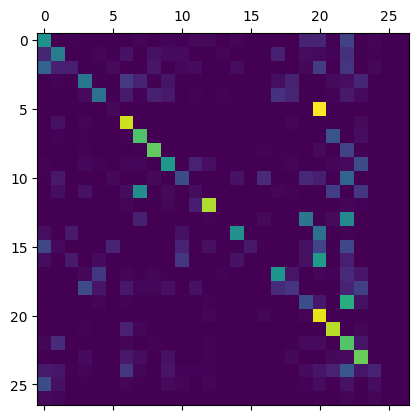

[[1909.    8.   35.    2.    0.    0.    0.   46.    9.   56.   40.   94.   82.    0.   67.    3.    4.    0.    0.  353.  388.   21.  730.    1.   70.    0.    0.]
 [ 391. 1593.   10.    6.   63.   21.  183.    3.  172.  108.  113.   13.    2.   58.    3.    2.   22.  325.    9.  124.   81.   35.  518.   24.   30.    0.    0.]
 [1188.  325.  319.    0.   15.   93.    0.    0.  230.    0.   76.  112.    2.    0.  121.    0.   11.    0.    0.   87.  673.    0.  582.    0.   75.    0.    0.]
 [   1.   35.    0. 1467.   24.    0.  618.  366.   24.  219.    5.   19.    5.   11.    0.    0.    0.  140.  349.    2.    1.   88.  142.  391.    2.    0.    0.]
 [   2.   27.    0.  100. 1417.    0.  276.   33.  334.  258.    3.   35.    8.   43.    0.    0.   25.  536.  392.   16.    3.   38.  257.  104.    2.    0.    0.]
 [  20.    3.    1.    0.    0.   81.    0.    0.    0.    4.    6.    8.    8.    0.    9.    0.    2.    0.    1.    8. 3753.    0.    5.    0.    0.    0.    0.]
 [   0.  1

In [13]:
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

### 3.3. Transformer

Number of parameters: 679_067


  1%|          | 391/68609 [01:45<133:31:49,  7.05s/it]

N Reads: 50048 Loss: 911.77. F1: [0.4971, 0.17448]. Patience: 20


  1%|          | 782/68609 [03:42<187:16:23,  9.94s/it]

N Reads: 100096 Loss: 713.89. F1: [0.55589, 0.26355]. Patience: 20


  2%|▏         | 1173/68609 [05:35<148:52:10,  7.95s/it]

N Reads: 150144 Loss: 646.07. F1: [0.58945, 0.28393]. Patience: 20


  2%|▏         | 1564/68609 [07:31<147:50:52,  7.94s/it]

N Reads: 200192 Loss: 609.63. F1: [0.59354, 0.31574]. Patience: 20


  3%|▎         | 1955/68609 [09:28<150:28:02,  8.13s/it]

N Reads: 250240 Loss: 583.18. F1: [0.59814, 0.33352]. Patience: 20


  3%|▎         | 2346/68609 [11:26<146:50:00,  7.98s/it]

N Reads: 300288 Loss: 558.93. F1: [0.60293, 0.332]. Patience: 19


  4%|▍         | 2737/68609 [13:27<154:43:31,  8.46s/it]

N Reads: 350336 Loss: 538.76. F1: [0.61918, 0.35396]. Patience: 19


  5%|▍         | 3128/68609 [15:26<148:29:09,  8.16s/it]

N Reads: 400384 Loss: 524.40. F1: [0.62173, 0.37399]. Patience: 19


  5%|▌         | 3519/68609 [17:25<142:23:27,  7.88s/it]

N Reads: 450432 Loss: 508.73. F1: [0.62608, 0.36779]. Patience: 18


  6%|▌         | 3910/68609 [19:25<145:07:12,  8.07s/it]

N Reads: 500480 Loss: 497.27. F1: [0.62774, 0.3496]. Patience: 17


  6%|▋         | 4301/68609 [21:25<145:01:48,  8.12s/it]

N Reads: 550528 Loss: 486.27. F1: [0.5917, 0.37578]. Patience: 17


  7%|▋         | 4692/68609 [23:25<144:06:42,  8.12s/it]

N Reads: 600576 Loss: 477.84. F1: [0.64792, 0.39183]. Patience: 17


  7%|▋         | 5083/68609 [25:28<147:15:04,  8.34s/it]

N Reads: 650624 Loss: 471.44. F1: [0.67596, 0.41339]. Patience: 17


  8%|▊         | 5474/68609 [27:29<139:55:18,  7.98s/it]

N Reads: 700672 Loss: 462.65. F1: [0.65489, 0.40595]. Patience: 16


  9%|▊         | 5865/68609 [29:32<143:19:04,  8.22s/it]

N Reads: 750720 Loss: 453.41. F1: [0.67, 0.40212]. Patience: 15


  9%|▉         | 6256/68609 [31:33<137:14:57,  7.92s/it]

N Reads: 800768 Loss: 451.60. F1: [0.6648, 0.41126]. Patience: 14


 10%|▉         | 6647/68609 [33:33<136:55:44,  7.96s/it]

N Reads: 850816 Loss: 440.37. F1: [0.67993, 0.42699]. Patience: 14


 10%|█         | 7038/68609 [35:33<133:38:12,  7.81s/it]

N Reads: 900864 Loss: 435.16. F1: [0.66747, 0.42261]. Patience: 13


 11%|█         | 7429/68609 [37:34<134:38:18,  7.92s/it]

N Reads: 950912 Loss: 429.51. F1: [0.66735, 0.41671]. Patience: 12


 11%|█▏        | 7820/68609 [39:36<135:30:43,  8.03s/it]

N Reads: 1000960 Loss: 422.49. F1: [0.66844, 0.42615]. Patience: 11


 12%|█▏        | 8211/68609 [41:37<134:24:39,  8.01s/it]

N Reads: 1051008 Loss: 421.97. F1: [0.65132, 0.42881]. Patience: 11


 13%|█▎        | 8602/68609 [44:06<127:34:18,  7.65s/it]

N Reads: 1101056 Loss: 414.97. F1: [0.6672, 0.43109]. Patience: 11


 13%|█▎        | 8993/68609 [46:07<132:59:39,  8.03s/it]

N Reads: 1151104 Loss: 412.76. F1: [0.67095, 0.42272]. Patience: 10


 14%|█▎        | 9384/68609 [48:10<132:20:37,  8.04s/it]

N Reads: 1201152 Loss: 407.97. F1: [0.68575, 0.44674]. Patience: 10


 14%|█▍        | 9775/68609 [50:13<131:06:48,  8.02s/it]

N Reads: 1251200 Loss: 402.85. F1: [0.67516, 0.43399]. Patience: 9


 15%|█▍        | 10166/68609 [52:18<132:48:25,  8.18s/it]

N Reads: 1301248 Loss: 400.00. F1: [0.65776, 0.43275]. Patience: 8


 15%|█▌        | 10557/68609 [54:22<131:15:02,  8.14s/it]

N Reads: 1351296 Loss: 395.11. F1: [0.68288, 0.44628]. Patience: 7


 16%|█▌        | 10948/68609 [56:27<128:06:49,  8.00s/it]

N Reads: 1401344 Loss: 391.79. F1: [0.68724, 0.44161]. Patience: 6


 17%|█▋        | 11339/68609 [58:28<123:29:23,  7.76s/it]

N Reads: 1451392 Loss: 388.66. F1: [0.68047, 0.44923]. Patience: 6


 17%|█▋        | 11730/68609 [1:00:28<121:23:26,  7.68s/it]

N Reads: 1501440 Loss: 385.04. F1: [0.68823, 0.45717]. Patience: 6


 18%|█▊        | 12121/68609 [1:02:28<121:56:56,  7.77s/it]

N Reads: 1551488 Loss: 379.60. F1: [0.68229, 0.44999]. Patience: 5


 18%|█▊        | 12512/68609 [1:04:30<123:52:47,  7.95s/it]

N Reads: 1601536 Loss: 379.15. F1: [0.68056, 0.45731]. Patience: 5


 19%|█▉        | 12903/68609 [1:06:31<121:02:47,  7.82s/it]

N Reads: 1651584 Loss: 375.35. F1: [0.67188, 0.43718]. Patience: 4


 19%|█▉        | 13294/68609 [1:08:31<118:08:41,  7.69s/it]

N Reads: 1701632 Loss: 378.56. F1: [0.67975, 0.45168]. Patience: 3


 20%|█▉        | 13685/68609 [1:10:32<118:31:09,  7.77s/it]

N Reads: 1751680 Loss: 377.47. F1: [0.70451, 0.4554]. Patience: 2


 21%|██        | 14076/68609 [1:12:33<115:36:26,  7.63s/it]

N Reads: 1801728 Loss: 368.50. F1: [0.68398, 0.43696]. Patience: 1


 21%|██        | 14466/68609 [1:14:35<4:39:09,  3.23it/s]  

N Reads: 1851776 Loss: 368.06. F1: [0.69193, 0.44601]. Patience: 0
The model is overfitting; stopping early.
Processed 1_851_776 reads.
Training took 4475.196 s.


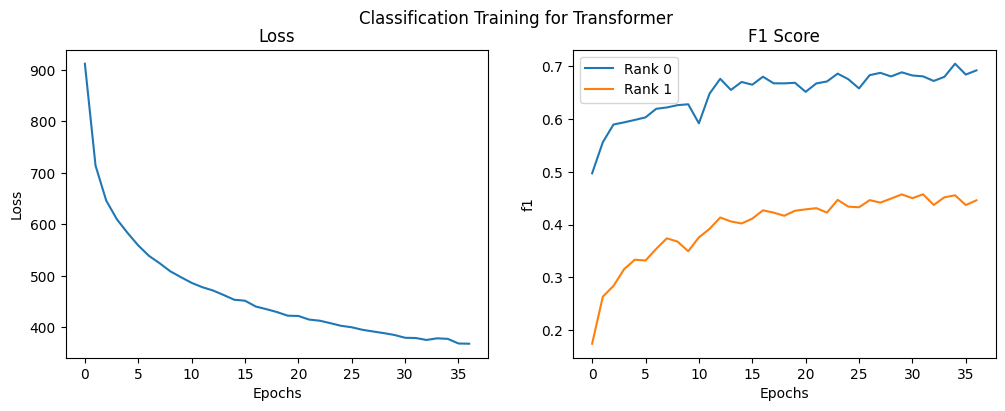

Test results: [0.69433, 0.43965]


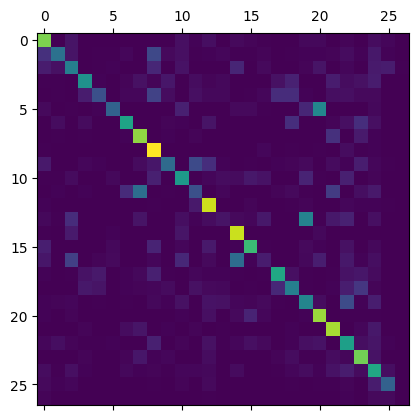

[[2859.    1.  182.    0.    0.    2.    0.    1.    0.    0.  147.   36.  135.    1.   86.   45.   14.    0.    0.   81.   81.    8.   50.    6.  123.   60.    0.]
 [ 496. 1331.  184.    4.   26.   19.   66.    9.  776.   84.  144.   15.   37.   68.   19.   20.   45.   11.   22.   41.   32.   47.  117.   31.  235.   29.    1.]
 [ 268.  163. 1535.    0.   18.   33.    3.    0.  384.    0.  167.    9.   11.    1.  365.    1.   92.   11.    0.   54.  190.    0.   58.    4.  259.  269.   14.]
 [  15.   16.    1. 1798.   29.    0.   52.  161.   47.  212.    2.  114.   49.   73.    0.    1.   13.  157.  322.   11.    5.  277.  118.  161.  269.    5.    1.]
 [   9.   27.   12.  273.  861.    0.   57.   57.  703.  114.   10.  148.   79.   80.    0.   17.   56.  449.  456.   34.    8.  130.  143.   96.   86.    4.    0.]
 [  93.    0.   19.    0.   32. 1122.    8.    0.    5.    0.  317.    0.    3.    0.   84.   86.   17.    0.    0.  386. 1644.    0.   13.    2.   76.    2.    0.]
 [   1.  1

In [11]:
from torch import  arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)


class T_1_tokens(Module):
    def __init__(self, N, M):
        super(T_1_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=3)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    transformer.Classifier(LENGTH // 4, mapping, "cuda", T_1_tokens, use_tokens=True),
    "Transformer",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

Number of parameters: 480_795


  1%|          | 392/68609 [01:12<65:57:18,  3.48s/it]

N Reads: 50048 Loss: 895.81. F1: [0.46784, 0.1771]. Patience: 20


  1%|          | 783/68609 [02:25<70:57:30,  3.77s/it] 

N Reads: 100096 Loss: 690.63. F1: [0.57019, 0.29199]. Patience: 20


  2%|▏         | 1174/68609 [03:39<70:56:33,  3.79s/it] 

N Reads: 150144 Loss: 629.58. F1: [0.59446, 0.3008]. Patience: 20


  2%|▏         | 1565/68609 [04:53<70:54:31,  3.81s/it] 

N Reads: 200192 Loss: 587.66. F1: [0.60096, 0.32612]. Patience: 20


  3%|▎         | 1956/68609 [06:08<69:32:19,  3.76s/it]

N Reads: 250240 Loss: 561.38. F1: [0.61885, 0.36086]. Patience: 20


  3%|▎         | 2347/68609 [07:24<67:56:42,  3.69s/it]

N Reads: 300288 Loss: 533.71. F1: [0.63972, 0.36957]. Patience: 20


  4%|▍         | 2738/68609 [08:40<67:45:58,  3.70s/it]

N Reads: 350336 Loss: 515.96. F1: [0.62479, 0.38126]. Patience: 20


  5%|▍         | 3129/68609 [09:56<67:36:09,  3.72s/it]

N Reads: 400384 Loss: 499.09. F1: [0.64054, 0.39052]. Patience: 20


  5%|▌         | 3520/68609 [11:12<67:09:27,  3.71s/it]

N Reads: 450432 Loss: 485.84. F1: [0.66148, 0.39634]. Patience: 20


  6%|▌         | 3911/68609 [12:28<66:16:57,  3.69s/it]

N Reads: 500480 Loss: 473.83. F1: [0.66595, 0.39364]. Patience: 19


  6%|▋         | 4302/68609 [13:46<67:10:30,  3.76s/it]

N Reads: 550528 Loss: 463.12. F1: [0.62791, 0.40598]. Patience: 19


  7%|▋         | 4693/68609 [15:03<65:59:30,  3.72s/it]

N Reads: 600576 Loss: 453.21. F1: [0.66566, 0.416]. Patience: 19


  7%|▋         | 5084/68609 [16:20<65:10:18,  3.69s/it]

N Reads: 650624 Loss: 447.43. F1: [0.6564, 0.41712]. Patience: 19


  8%|▊         | 5475/68609 [17:37<65:47:58,  3.75s/it]

N Reads: 700672 Loss: 438.90. F1: [0.67232, 0.40982]. Patience: 18


  9%|▊         | 5866/68609 [18:55<64:11:42,  3.68s/it]

N Reads: 750720 Loss: 429.07. F1: [0.69189, 0.42246]. Patience: 18


  9%|▉         | 6257/68609 [20:12<64:05:49,  3.70s/it]

N Reads: 800768 Loss: 425.75. F1: [0.67859, 0.43344]. Patience: 18


 10%|▉         | 6648/68609 [21:29<62:31:11,  3.63s/it]

N Reads: 850816 Loss: 416.52. F1: [0.67841, 0.44525]. Patience: 18


 10%|█         | 7039/68609 [22:46<62:26:58,  3.65s/it]

N Reads: 900864 Loss: 409.97. F1: [0.69049, 0.44184]. Patience: 17


 11%|█         | 7430/68609 [24:03<61:21:29,  3.61s/it]

N Reads: 950912 Loss: 406.28. F1: [0.66943, 0.42561]. Patience: 16


 11%|█▏        | 7821/68609 [25:20<61:01:36,  3.61s/it]

N Reads: 1000960 Loss: 400.27. F1: [0.68578, 0.44743]. Patience: 16


 12%|█▏        | 8212/68609 [26:36<60:35:41,  3.61s/it]

N Reads: 1051008 Loss: 400.44. F1: [0.66068, 0.43885]. Patience: 15


 13%|█▎        | 8603/68609 [27:54<59:59:50,  3.60s/it]

N Reads: 1101056 Loss: 393.40. F1: [0.67331, 0.44367]. Patience: 14


 13%|█▎        | 8994/68609 [29:11<59:37:33,  3.60s/it]

N Reads: 1151104 Loss: 391.51. F1: [0.6776, 0.44116]. Patience: 13


 14%|█▎        | 9385/68609 [30:28<59:00:19,  3.59s/it]

N Reads: 1201152 Loss: 388.32. F1: [0.70119, 0.46333]. Patience: 13


 14%|█▍        | 9776/68609 [31:46<60:26:36,  3.70s/it]

N Reads: 1251200 Loss: 384.09. F1: [0.66555, 0.4484]. Patience: 12


 15%|█▍        | 10167/68609 [33:04<58:52:54,  3.63s/it]

N Reads: 1301248 Loss: 380.60. F1: [0.66798, 0.45391]. Patience: 11


 15%|█▌        | 10558/68609 [34:22<58:42:37,  3.64s/it]

N Reads: 1351296 Loss: 377.24. F1: [0.6869, 0.45463]. Patience: 10


 16%|█▌        | 10949/68609 [35:40<56:34:51,  3.53s/it]

N Reads: 1401344 Loss: 373.13. F1: [0.68748, 0.4581]. Patience: 9


 17%|█▋        | 11340/68609 [36:59<59:24:45,  3.73s/it]

N Reads: 1451392 Loss: 372.45. F1: [0.6872, 0.45328]. Patience: 8


 17%|█▋        | 11731/68609 [38:20<57:59:41,  3.67s/it]

N Reads: 1501440 Loss: 370.11. F1: [0.68564, 0.46823]. Patience: 8


 18%|█▊        | 12122/68609 [39:39<57:24:59,  3.66s/it]

N Reads: 1551488 Loss: 363.59. F1: [0.68819, 0.4616]. Patience: 7


 18%|█▊        | 12513/68609 [40:57<54:51:14,  3.52s/it]

N Reads: 1601536 Loss: 362.51. F1: [0.69532, 0.46556]. Patience: 6


 19%|█▉        | 12904/68609 [42:15<54:34:56,  3.53s/it]

N Reads: 1651584 Loss: 360.88. F1: [0.67659, 0.44712]. Patience: 5


 19%|█▉        | 13295/68609 [43:33<54:03:21,  3.52s/it]

N Reads: 1701632 Loss: 362.45. F1: [0.69595, 0.45446]. Patience: 4


 20%|█▉        | 13686/68609 [44:52<55:54:39,  3.66s/it]

N Reads: 1751680 Loss: 358.41. F1: [0.69712, 0.47419]. Patience: 4


 21%|██        | 14077/68609 [46:12<54:41:44,  3.61s/it]

N Reads: 1801728 Loss: 353.14. F1: [0.69421, 0.46204]. Patience: 3


 21%|██        | 14468/68609 [47:30<53:21:36,  3.55s/it]

N Reads: 1851776 Loss: 352.85. F1: [0.70327, 0.46728]. Patience: 2


 22%|██▏       | 14859/68609 [48:49<53:38:12,  3.59s/it]

N Reads: 1901824 Loss: 349.68. F1: [0.67306, 0.45246]. Patience: 1


 22%|██▏       | 15248/68609 [50:08<2:55:28,  5.07it/s] 

N Reads: 1951872 Loss: 346.52. F1: [0.68995, 0.46088]. Patience: 0
The model is overfitting; stopping early.
Processed 1_951_872 reads.


Training took 3008.956 s.


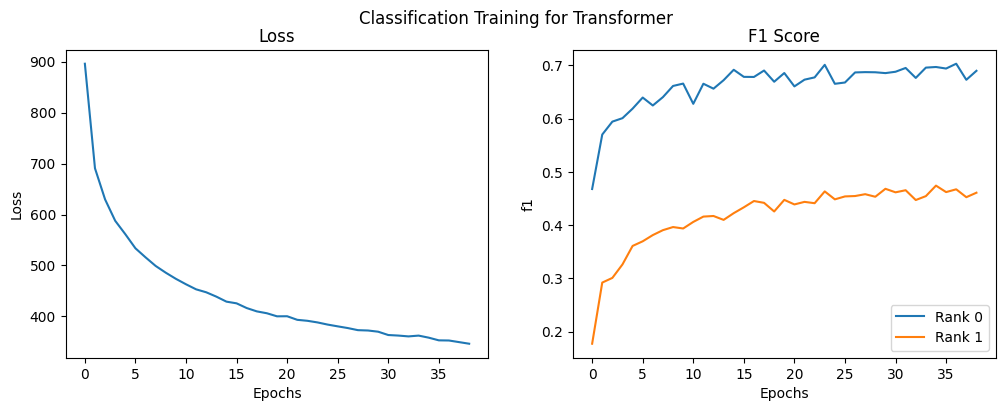

Test results: [0.70656, 0.47211]


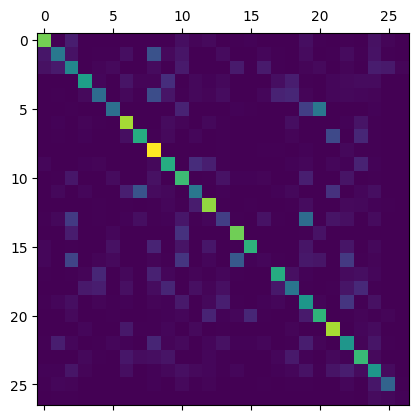

[[2851.   13.  296.    0.    0.    5.    2.    0.    5.    8.  132.   44.   95.    5.   20.   29.   13.    0.    0.  129.   15.    8.   28.    1.  165.   53.    1.]
 [ 215. 1445.  178.    1.   18.   15.  140.    6.  904.   85.  199.   11.   14.  107.    6.    7.   57.   26.   10.   99.   10.   21.  106.   23.  181.   24.    1.]
 [ 157.  256. 1679.    0.   50.   86.    0.    0.  110.    2.  257.    9.    2.    2.  268.    0.  259.   17.    0.   44.   92.    0.   53.    2.  275.  246.   43.]
 [  14.   13.    0. 2044.   64.    0.  184.   43.   48.  466.    9.   77.   33.   78.    0.    1.    5.  132.  288.   25.    6.   70.   90.  112.   99.    8.    0.]
 [   6.   23.    3.   87. 1273.    0.   76.   20.  849.  200.   18.   81.   44.  114.    0.    3.   60.  350.  381.   49.   14.   63.   82.   57.   50.    5.    1.]
 [   8.    0.   21.    0.    6. 1318.    4.    0.    2.    0.  341.    1.    5.    0.   36.   16.    3.    0.    0.  664. 1429.    0.   14.    0.   39.    2.    0.]
 [   0.   

In [8]:
from torch import arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)


class T_2_tokens(Module):
    def __init__(self, N, M):
        super(T_2_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    transformer.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens, use_tokens=True),
    "Transformer",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

### 3.4. Autoencoders

Number of parameters: 73_427_257


  1%|          | 395/68609 [00:27<7:44:38,  2.45it/s] 

N Reads: 50048 Loss: 314.75. F1: [0.35615, 0.070641]. Patience: 30


  1%|          | 787/68609 [00:48<9:50:22,  1.91it/s] 

N Reads: 100096 Loss: 281.67. F1: [0.40199, 0.11616]. Patience: 30


  2%|▏         | 1177/68609 [01:09<10:09:29,  1.84it/s]

N Reads: 150144 Loss: 264.40. F1: [0.47945, 0.14751]. Patience: 30


  2%|▏         | 1566/68609 [01:30<13:12:24,  1.41it/s]

N Reads: 200192 Loss: 245.43. F1: [0.49689, 0.20127]. Patience: 30


  3%|▎         | 1957/68609 [01:51<13:10:09,  1.41it/s]

N Reads: 250240 Loss: 234.45. F1: [0.41366, 0.20009]. Patience: 29


  3%|▎         | 2350/68609 [02:13<9:51:29,  1.87it/s] 

N Reads: 300288 Loss: 226.84. F1: [0.43025, 0.23759]. Patience: 29


  4%|▍         | 2740/68609 [02:34<10:42:38,  1.71it/s]

N Reads: 350336 Loss: 221.63. F1: [0.50459, 0.25269]. Patience: 29


  5%|▍         | 3132/68609 [02:56<10:58:47,  1.66it/s]

N Reads: 400384 Loss: 217.29. F1: [0.44896, 0.26531]. Patience: 29


  5%|▌         | 3523/68609 [03:18<10:28:57,  1.72it/s]

N Reads: 450432 Loss: 213.08. F1: [0.51503, 0.27383]. Patience: 29


  6%|▌         | 3912/68609 [03:40<13:45:05,  1.31it/s]

N Reads: 500480 Loss: 209.25. F1: [0.52694, 0.27584]. Patience: 29


  6%|▋         | 4304/68609 [04:02<10:13:40,  1.75it/s]

N Reads: 550528 Loss: 206.04. F1: [0.50893, 0.29217]. Patience: 29


  7%|▋         | 4695/68609 [04:24<9:43:11,  1.83it/s] 

N Reads: 600576 Loss: 202.98. F1: [0.54184, 0.3127]. Patience: 29


  7%|▋         | 5087/68609 [04:45<9:16:21,  1.90it/s] 

N Reads: 650624 Loss: 200.85. F1: [0.50163, 0.2967]. Patience: 28


  8%|▊         | 5478/68609 [05:08<9:10:50,  1.91it/s] 

N Reads: 700672 Loss: 198.46. F1: [0.55178, 0.33589]. Patience: 28


  9%|▊         | 5868/68609 [05:30<9:35:44,  1.82it/s] 

N Reads: 750720 Loss: 195.18. F1: [0.55984, 0.31515]. Patience: 27


  9%|▉         | 6259/68609 [05:52<10:40:47,  1.62it/s]

N Reads: 800768 Loss: 195.12. F1: [0.60989, 0.34755]. Patience: 27


 10%|▉         | 6650/68609 [06:15<10:51:55,  1.58it/s]

N Reads: 850816 Loss: 193.25. F1: [0.62941, 0.37061]. Patience: 27


 10%|█         | 7040/68609 [06:38<13:12:20,  1.30it/s]

N Reads: 900864 Loss: 191.06. F1: [0.56294, 0.33412]. Patience: 26


 11%|█         | 7433/68609 [07:01<9:02:38,  1.88it/s] 

N Reads: 950912 Loss: 190.02. F1: [0.61369, 0.353]. Patience: 25


 11%|█▏        | 7823/68609 [07:24<9:12:41,  1.83it/s] 

N Reads: 1000960 Loss: 187.54. F1: [0.57164, 0.33991]. Patience: 24


 12%|█▏        | 8214/68609 [07:49<11:17:23,  1.49it/s]

N Reads: 1051008 Loss: 186.90. F1: [0.55528, 0.36551]. Patience: 23


 13%|█▎        | 8607/68609 [08:11<7:40:23,  2.17it/s] 

N Reads: 1101056 Loss: 186.61. F1: [0.58116, 0.36923]. Patience: 22


 13%|█▎        | 8997/68609 [08:33<7:34:15,  2.19it/s] 

N Reads: 1151104 Loss: 183.47. F1: [0.63061, 0.39051]. Patience: 22


 14%|█▎        | 9387/68609 [08:56<8:51:50,  1.86it/s] 

N Reads: 1201152 Loss: 183.31. F1: [0.62816, 0.38946]. Patience: 21


 14%|█▍        | 9777/68609 [09:19<11:54:38,  1.37it/s]

N Reads: 1251200 Loss: 183.35. F1: [0.64102, 0.39166]. Patience: 21


 15%|█▍        | 10169/68609 [09:42<8:49:44,  1.84it/s] 

N Reads: 1301248 Loss: 182.03. F1: [0.58628, 0.37172]. Patience: 20


 15%|█▌        | 10561/68609 [10:05<7:30:48,  2.15it/s] 

N Reads: 1351296 Loss: 179.56. F1: [0.64871, 0.40405]. Patience: 20


 16%|█▌        | 10951/68609 [10:28<8:23:18,  1.91it/s] 

N Reads: 1401344 Loss: 179.47. F1: [0.64357, 0.39274]. Patience: 19


 17%|█▋        | 11344/68609 [10:51<7:13:28,  2.20it/s] 

N Reads: 1451392 Loss: 180.00. F1: [0.62574, 0.39921]. Patience: 18


 17%|█▋        | 11734/68609 [11:14<7:38:27,  2.07it/s] 

N Reads: 1501440 Loss: 178.37. F1: [0.61565, 0.41102]. Patience: 18


 18%|█▊        | 12124/68609 [11:38<8:28:44,  1.85it/s] 

N Reads: 1551488 Loss: 175.95. F1: [0.6435, 0.41247]. Patience: 18


 18%|█▊        | 12514/68609 [12:02<11:11:13,  1.39it/s]

N Reads: 1601536 Loss: 175.66. F1: [0.62886, 0.397]. Patience: 17


 19%|█▉        | 12907/68609 [12:26<8:00:49,  1.93it/s] 

N Reads: 1651584 Loss: 175.08. F1: [0.65311, 0.4045]. Patience: 16


 19%|█▉        | 13297/68609 [12:53<9:40:48,  1.59it/s] 

N Reads: 1701632 Loss: 177.00. F1: [0.6614, 0.42409]. Patience: 16


 20%|█▉        | 13689/68609 [13:17<6:46:11,  2.25it/s]

N Reads: 1751680 Loss: 175.12. F1: [0.67439, 0.4127]. Patience: 15


 21%|██        | 14079/68609 [13:40<6:45:29,  2.24it/s]

N Reads: 1801728 Loss: 173.24. F1: [0.67286, 0.4047]. Patience: 14


 21%|██        | 14469/68609 [14:03<9:12:37,  1.63it/s]

N Reads: 1851776 Loss: 172.94. F1: [0.65063, 0.39881]. Patience: 13


 22%|██▏       | 14862/68609 [14:26<6:29:30,  2.30it/s]

N Reads: 1901824 Loss: 171.74. F1: [0.66558, 0.40871]. Patience: 12


 22%|██▏       | 15252/68609 [14:49<6:37:13,  2.24it/s]

N Reads: 1951872 Loss: 171.46. F1: [0.65953, 0.39119]. Patience: 11


 23%|██▎       | 15642/68609 [15:12<8:49:53,  1.67it/s]

N Reads: 2001920 Loss: 169.86. F1: [0.65775, 0.42315]. Patience: 10


 23%|██▎       | 16034/68609 [15:35<6:22:04,  2.29it/s]

N Reads: 2051968 Loss: 170.85. F1: [0.66588, 0.41423]. Patience: 9


 24%|██▍       | 16427/68609 [15:58<6:15:49,  2.31it/s]

N Reads: 2102016 Loss: 170.17. F1: [0.66533, 0.40376]. Patience: 8


 25%|██▍       | 16817/68609 [16:21<6:15:18,  2.30it/s]

N Reads: 2152064 Loss: 168.61. F1: [0.64297, 0.39754]. Patience: 7


 25%|██▌       | 17207/68609 [16:45<6:14:15,  2.29it/s]

N Reads: 2202112 Loss: 168.72. F1: [0.66909, 0.42075]. Patience: 6


 26%|██▌       | 17600/68609 [17:08<6:20:53,  2.23it/s]

N Reads: 2252160 Loss: 168.01. F1: [0.66643, 0.40902]. Patience: 5


 26%|██▌       | 17990/68609 [17:32<6:02:08,  2.33it/s]

N Reads: 2302208 Loss: 167.09. F1: [0.68567, 0.40898]. Patience: 4


 27%|██▋       | 18380/68609 [17:55<6:05:54,  2.29it/s]

N Reads: 2352256 Loss: 166.66. F1: [0.6654, 0.42653]. Patience: 4


 27%|██▋       | 18773/68609 [18:19<5:57:44,  2.32it/s]

N Reads: 2402304 Loss: 164.68. F1: [0.70759, 0.4353]. Patience: 4


 28%|██▊       | 19163/68609 [18:43<5:49:17,  2.36it/s]

N Reads: 2452352 Loss: 165.83. F1: [0.6518, 0.42472]. Patience: 3


 28%|██▊       | 19553/68609 [19:06<5:46:07,  2.36it/s]

N Reads: 2502400 Loss: 165.62. F1: [0.67917, 0.42224]. Patience: 2


 29%|██▉       | 19943/68609 [19:30<7:47:21,  1.74it/s]

N Reads: 2552448 Loss: 164.66. F1: [0.65716, 0.41341]. Patience: 1


 30%|██▉       | 20336/68609 [19:54<5:45:03,  2.33it/s]

N Reads: 2602496 Loss: 164.23. F1: [0.68696, 0.43766]. Patience: 1


 30%|███       | 20726/68609 [20:19<6:26:43,  2.06it/s]

N Reads: 2652544 Loss: 163.55. F1: [0.67588, 0.46205]. Patience: 1


 31%|███       | 21113/68609 [20:46<46:43, 16.94it/s]  

N Reads: 2702592 Loss: 164.43. F1: [0.68181, 0.43344]. Patience: 0
The model is overfitting; stopping early.
Processed 2_702_592 reads.
Training took 1246.218 s.


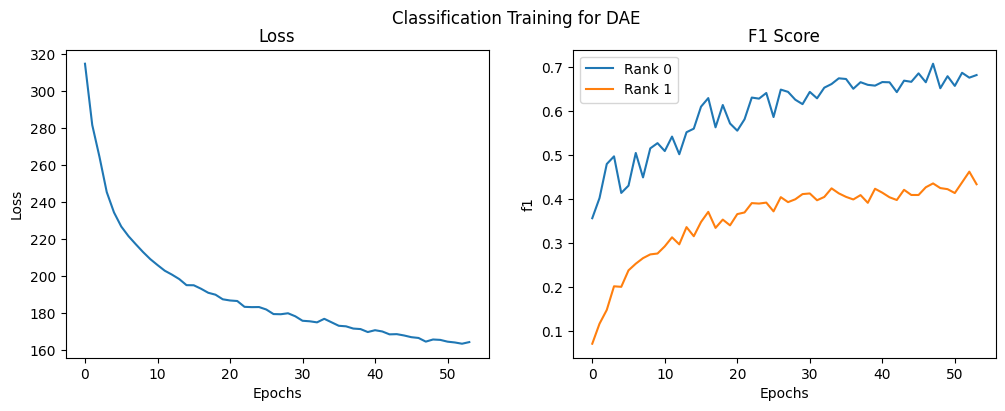

Test results: [0.70319, 0.45316]


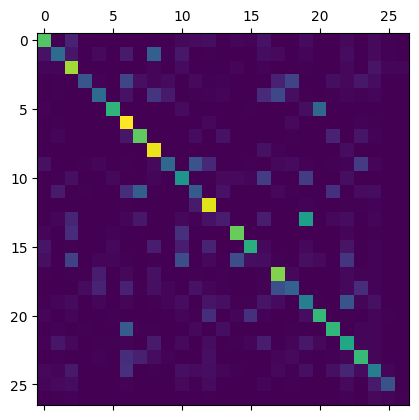

[[2642.    8.  365.    0.    0.    2.    3.    0.    1.    0.   77.   99.  140.    1.   58.   36.  174.    1.    0.  108.    1.    8.   81.    0.   93.   20.    0.]
 [ 176. 1267.  221.    0.   85.    7.  255.    1. 1080.   16.  233.    5.   27.   12.    0.    6.  113.   86.    5.   67.    3.    2.  119.    3.   98.   22.    0.]
 [  47.   58. 3108.    0.    5.    8.    1.    0.   57.    2.  112.    5.   12.    0.   59.    0.   36.    3.    0.   28.    5.    0.   73.    1.  189.   43.   57.]
 [   3.   21.    7.  965.   40.    0.  750.  144.   61.  103.    9.   85.   18.   40.    0.    1.    4.  338.  743.    7.    1.  128.   83.  234.  121.    3.    0.]
 [   1.   25.   10.   14. 1255.    0.  174.    1.  541.  261.    7.   20.   30.   67.    0.    3.  426.  767.  131.   18.    4.   26.   45.   29.   51.    3.    0.]
 [  30.    0.   13.    0.    0. 2353.    7.    0.   11.    0.  104.    4.    6.    0.    8.   24.    1.    0.    0.  129. 1206.    0.   11.    0.    2.    0.    0.]
 [   1.   

In [3]:
from torch import clamp, tensor
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d, LeakyReLU, ConvTranspose1d, Sigmoid)
from torch import stack, tensor, float32
from torch.func import vmap
import torch.nn.functional as F


class Unsqueeze(Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x.unsqueeze(self.dim)


class DAE_1(Module):
    """Denoising autoencoder 1."""
    def __init__(self, N, M):
        super(DAE_1, self).__init__()
        LATENT_SPACE_SIZE = 128
        self.encoder = Sequential(
            Conv1d(4, 32, kernel_size=5, padding=2),
            LeakyReLU(),
            MaxPool1d(kernel_size=2),
            Conv1d(32, 64, kernel_size=3, padding=1),
            LeakyReLU(),
            Flatten(),
            Linear(N * 64 // 2, N),
            LeakyReLU(),
            Linear(N, LATENT_SPACE_SIZE),
            LeakyReLU(),
        )
        self.decoder = Sequential(
            Linear(LATENT_SPACE_SIZE, N // 2),
            LeakyReLU(),
            Linear(N // 2, N),
            LeakyReLU(),
            Unsqueeze(1),
            ConvTranspose1d(1, 4, kernel_size=3, stride=1, padding=1),
            LeakyReLU(),
            Sigmoid(),
        )
        self.classifier = Linear(LATENT_SPACE_SIZE, M)

    def forward(self, x):
        if self.training:
            x_noisy = autoencoder.add_masking_noise(x, dropout_prob=0.2)
            x_noisy = clamp(x_noisy, 0.0, 1.0)
            latent = self.encoder(x_noisy)
        else:
            B, N = x.shape
            shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
            x_expanded = x.unsqueeze(-1).to(int)
            tokens = (x_expanded >> shifts) & 0b11
            tokens = tokens.view(B, N * 4)
            one_hot = F.one_hot(tokens, num_classes=4).float()
            x = one_hot.permute(0, 2, 1)
            latent = self.encoder(x)
        classification = self.classifier(latent)
        reconstruction = self.decoder(latent)
        return classification, reconstruction


model = benchmark(
    autoencoder.Classifier(LENGTH, mapping, "cuda", DAE_1),
    "DAE",
    n_max_reads=8_000_000,
    patience=30,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

In [ ]:
from torch import arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)


class T_DAE_hybrid(Module):
    def __init__(self, N, M):
        super(T_DAE_hybrid, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = Linear(embed_dim, M)
        self.decoder = Sequential(
            Linear(embed_dim, N // 2),
            LeakyReLU(),
            Linear(N // 2, N),
            LeakyReLU(),
            Unsqueeze(1),
            ConvTranspose1d(1, 4, kernel_size=3, stride=1, padding=1),
            LeakyReLU(),
            Sigmoid(),
        )

    def forward(self, x):
        if self.training:
            x_noisy = autoencoder.add_masking_noise(x, dropout_prob=0.2)
            x_noisy = clamp(x_noisy, 0.0, 1.0)
            latent = self.encoder(x_noisy)
        else:
            B, N = x.shape
            shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
            x_expanded = x.unsqueeze(-1).to(int)
            tokens = (x_expanded >> shifts) & 0b11
            tokens = tokens.view(B, N * 4)
            one_hot = F.one_hot(tokens, num_classes=4).float()
            x = one_hot.permute(0, 2, 1)
            latent = self.encoder(x)
        classification = self.classifier(latent)
        reconstruction = self.decoder(latent)
        return classification, reconstruction

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    transformer.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens, use_tokens=True),
    "Transformer",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

### 3.5. Transformer / Denoising Autoencoder Hybrid Model

Number of parameters: 1_093_186


  1%|          | 392/68609 [01:12<66:39:26,  3.52s/it]

N Reads: 50_048 Loss: 285.22. F1: [0.50342, 0.16581]. Patience: 20


  1%|          | 783/68609 [02:37<107:12:48,  5.69s/it]

N Reads: 100_096 Loss: 229.19. F1: [0.59784, 0.2559]. Patience: 20


  2%|▏         | 1174/68609 [03:57<76:27:09,  4.08s/it] 

N Reads: 150_144 Loss: 212.24. F1: [0.59719, 0.31441]. Patience: 20


  2%|▏         | 1565/68609 [05:34<117:54:53,  6.33s/it]

N Reads: 200_192 Loss: 201.42. F1: [0.6278, 0.31778]. Patience: 20


  3%|▎         | 1956/68609 [06:55<78:18:50,  4.23s/it] 

N Reads: 250_240 Loss: 194.85. F1: [0.60863, 0.34316]. Patience: 20


  3%|▎         | 2347/68609 [08:18<75:54:00,  4.12s/it] 

N Reads: 300_288 Loss: 190.72. F1: [0.624, 0.35247]. Patience: 20


  4%|▍         | 2738/68609 [09:41<75:38:14,  4.13s/it] 

N Reads: 350_336 Loss: 185.02. F1: [0.63951, 0.37382]. Patience: 20


  5%|▍         | 3129/68609 [11:06<81:03:26,  4.46s/it] 

N Reads: 400_384 Loss: 180.94. F1: [0.6423, 0.39403]. Patience: 20


  5%|▌         | 3520/68609 [12:54<100:08:50,  5.54s/it]

N Reads: 450_432 Loss: 176.77. F1: [0.65745, 0.37212]. Patience: 19


  6%|▌         | 3911/68609 [14:15<71:41:54,  3.99s/it] 

N Reads: 500_480 Loss: 175.24. F1: [0.6556, 0.37887]. Patience: 18


  6%|▋         | 4302/68609 [15:38<70:36:00,  3.95s/it]

N Reads: 550_528 Loss: 171.68. F1: [0.62875, 0.38656]. Patience: 17


  7%|▋         | 4693/68609 [17:00<70:34:11,  3.97s/it]

N Reads: 600_576 Loss: 169.68. F1: [0.64211, 0.38912]. Patience: 16


  7%|▋         | 5084/68609 [18:23<71:01:53,  4.03s/it] 

N Reads: 650_624 Loss: 167.90. F1: [0.66782, 0.41045]. Patience: 16


  8%|▊         | 5475/68609 [19:47<70:42:09,  4.03s/it]

N Reads: 700_672 Loss: 165.17. F1: [0.66919, 0.42495]. Patience: 16


  9%|▊         | 5866/68609 [21:10<68:25:58,  3.93s/it]

N Reads: 750_720 Loss: 162.79. F1: [0.67043, 0.42022]. Patience: 15


  9%|▉         | 6257/68609 [22:34<69:51:10,  4.03s/it]

N Reads: 800_768 Loss: 161.53. F1: [0.66516, 0.42401]. Patience: 14


 10%|▉         | 6648/68609 [23:58<69:13:36,  4.02s/it]

N Reads: 850_816 Loss: 159.33. F1: [0.65154, 0.43035]. Patience: 14


 10%|█         | 7039/68609 [25:22<68:15:28,  3.99s/it]

N Reads: 900_864 Loss: 159.49. F1: [0.68825, 0.42198]. Patience: 13


 11%|█         | 7429/68609 [26:46<93:49:38,  5.52s/it]

N Reads: 950_912 Loss: 157.12. F1: [0.68372, 0.45514]. Patience: 13


 11%|█▏        | 7821/68609 [28:11<67:55:50,  4.02s/it]

N Reads: 1_000_960 Loss: 156.76. F1: [0.67046, 0.42768]. Patience: 12


 12%|█▏        | 8212/68609 [29:35<68:14:27,  4.07s/it]

N Reads: 1_051_008 Loss: 154.05. F1: [0.6753, 0.45687]. Patience: 12


 13%|█▎        | 8603/68609 [31:00<66:19:09,  3.98s/it]

N Reads: 1_101_056 Loss: 153.39. F1: [0.68622, 0.44383]. Patience: 11


 13%|█▎        | 8994/68609 [32:26<66:34:40,  4.02s/it]

N Reads: 1_151_104 Loss: 152.36. F1: [0.67018, 0.44785]. Patience: 10


 14%|█▎        | 9385/68609 [33:50<64:54:26,  3.95s/it]

N Reads: 1_201_152 Loss: 152.07. F1: [0.67752, 0.44116]. Patience: 9


 14%|█▍        | 9776/68609 [35:16<65:17:26,  4.00s/it]

N Reads: 1_251_200 Loss: 151.03. F1: [0.67741, 0.4512]. Patience: 8


 15%|█▍        | 10167/68609 [37:09<62:07:52,  3.83s/it] 

N Reads: 1_301_248 Loss: 149.12. F1: [0.68768, 0.47092]. Patience: 8


 15%|█▌        | 10558/68609 [38:46<60:40:31,  3.76s/it]

N Reads: 1_351_296 Loss: 148.49. F1: [0.6825, 0.46221]. Patience: 7


 16%|█▌        | 10949/68609 [40:12<61:08:53,  3.82s/it]

N Reads: 1_401_344 Loss: 148.12. F1: [0.69484, 0.44923]. Patience: 6


 17%|█▋        | 11340/68609 [41:36<60:42:05,  3.82s/it]

N Reads: 1_451_392 Loss: 147.70. F1: [0.69502, 0.482]. Patience: 6


 17%|█▋        | 11731/68609 [43:01<62:32:41,  3.96s/it]

N Reads: 1_501_440 Loss: 146.06. F1: [0.69955, 0.461]. Patience: 5


 18%|█▊        | 12122/68609 [44:27<61:54:31,  3.95s/it]

N Reads: 1_551_488 Loss: 147.12. F1: [0.69171, 0.46812]. Patience: 4


 18%|█▊        | 12513/68609 [45:52<61:45:01,  3.96s/it]

N Reads: 1_601_536 Loss: 145.78. F1: [0.69995, 0.45242]. Patience: 3


 19%|█▉        | 12904/68609 [47:18<61:59:23,  4.01s/it]

N Reads: 1_651_584 Loss: 145.00. F1: [0.68756, 0.45095]. Patience: 2


 19%|█▉        | 13295/68609 [48:45<61:02:11,  3.97s/it]

N Reads: 1_701_632 Loss: 143.78. F1: [0.7039, 0.47367]. Patience: 1


 20%|█▉        | 13686/68609 [50:11<58:48:22,  3.85s/it]

N Reads: 1_751_680 Loss: 143.61. F1: [0.7093, 0.48701]. Patience: 1


 21%|██        | 14075/68609 [51:37<3:19:59,  4.54it/s] 

N Reads: 1_801_728 Loss: 143.14. F1: [0.68198, 0.46522]. Patience: 0
The model is overfitting; stopping early.
Processed 1_801_728 reads.
Training took 3097.089 s.


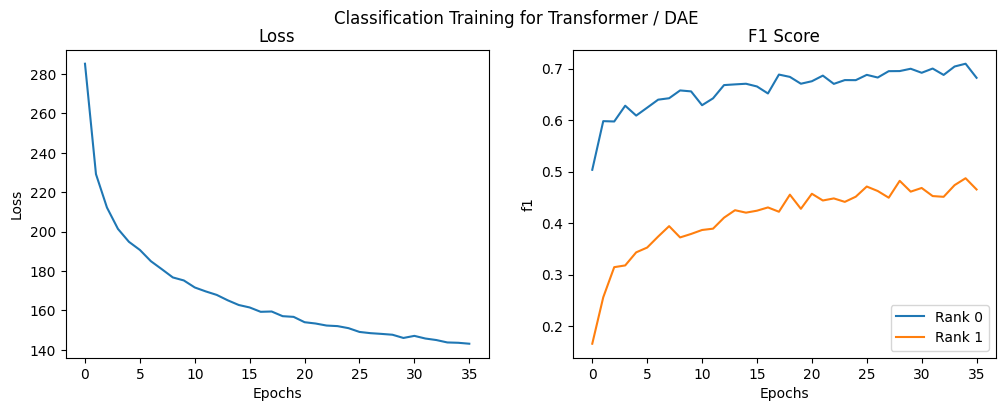

d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classe

Test results: [0.71448, 0.47493]


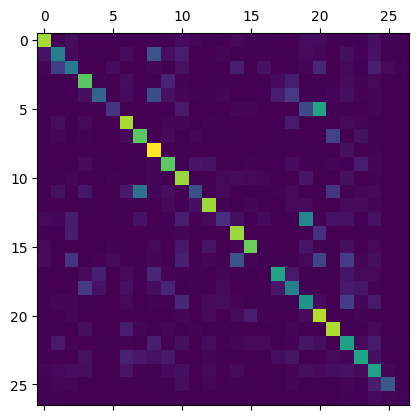

[[3072.    3.  118.    0.    1.    2.    3.    4.    0.   30.   98.   44.   24.    2.   72.   18.   15.    0.    0.  116.   98.   14.   14.   10.  145.   15.    0.]
 [ 176. 1536.   88.   10.   17.    9.   98.    9.  909.  147.  266.    4.   13.   53.   16.   16.   14.   12.   18.   94.   47.    7.  129.   28.  175.   17.    1.]
 [  52.  664. 1465.    0.    4.  101.    0.    0.   60.    2.  162.    2.   13.    2.  275.    1.  159.    2.    0.   45.  379.    0.   74.    7.  304.   95.   41.]
 [   8.   19.    0. 2641.   17.    0.  117.   27.   20.  341.   31.   11.    9.   25.    0.    1.    0.  111.  282.   18.    3.   25.  104.   28.   70.    1.    0.]
 [   2.   23.    2.  139. 1157.    1.  105.   20.  853.  164.   58.   33.   23.   57.    0.   13.   22.  282.  584.   36.   29.   67.  149.   29.   61.    0.    0.]
 [  35.    0.    4.    0.   14.  545.    2.    0.    2.    0.  247.    2.    4.    0.   60.   52.    0.    0.    0.  772. 2081.    0.   19.   10.   60.    0.    0.]
 [   0.  1

In [5]:
model = benchmark(
    hybrid.Classifier(LENGTH // 4, mapping, "cuda", hybrid.T_DAE_hybrid_1),
    "Transformer / DAE",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

In [4]:
from sklearn.metrics import precision_score


def rank_based_precision(
        mappings: dict, target: list[int], predictions: list[int]
        ) -> list[np.ndarray]:
    """Evaluate precision at multiple taxonomic ranks."""
    f = []
    for mapping in mappings:
        labels = list(set(mapping.values()))
        normalized_target = [mapping[int(v)] for v in list(target)]
        normalized_pred = [mapping[int(v)] for v in list(predictions)]
        f.append(
            precision_score(
                normalized_target,
                normalized_pred,
                average=None,
                labels=labels,
                zero_division=0.0
            )
        )
    return f


def evaluate(classifier, loader, device, mapping, permute=True):
    """Evaluate the F1 score at different taxonomic levels."""
    mappings = models.obtain_rank_based_mappings(mapping)
    ranks = []
    n_batches = 0
    with no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.type(float32).to(device)
            if permute:
                x_batch = x_batch.permute(0, 2, 1)  # Swap channels and sequence.
            y_batch = y_batch.to("cpu")
            predictions = classifier.predict(x_batch)
            ranks.append(rank_based_precision(mappings, y_batch, predictions))
            n_batches += 1
    collapsed_ranks = [np.zeros(len(r)) for r in ranks[0]]
    for rank in ranks:
        for i, result in enumerate(rank):
            collapsed_ranks[i] += result
    for i in range(len(collapsed_ranks)):
        collapsed_ranks[i] = np.mean(collapsed_ranks[i])
        collapsed_ranks[i] /= n_batches
    collapsed_ranks = [r for r in reversed(collapsed_ranks)]
    for i in range(len(collapsed_ranks) - 1):
        assert collapsed_ranks[i] > collapsed_ranks[i + 1]
    return collapsed_ranks

In [ ]:
result = evaluate(model, test_data, "cuda", mapping, permute=False)
rounded_result = [float(f"{r:.5}") for r in result]
print(rounded_result)

[0.7372, 0.50223]


Number of parameters: 2_408_386


  1%|          | 391/68609 [02:01<154:07:22,  8.13s/it]

N Reads: 50_048 Loss: 261.04. F1: [0.56094, 0.21786]. Patience: 20


  1%|          | 782/68609 [04:00<166:59:42,  8.86s/it]

N Reads: 100_096 Loss: 208.40. F1: [0.60297, 0.30613]. Patience: 20


  2%|▏         | 1173/68609 [06:20<230:18:12, 12.29s/it]

N Reads: 150_144 Loss: 196.55. F1: [0.63941, 0.36699]. Patience: 20


  2%|▏         | 1564/68609 [08:24<168:14:54,  9.03s/it]

N Reads: 200_192 Loss: 188.44. F1: [0.6394, 0.36304]. Patience: 19


  3%|▎         | 1955/68609 [10:57<265:25:19, 14.34s/it]

N Reads: 250_240 Loss: 181.56. F1: [0.6429, 0.39963]. Patience: 19


  3%|▎         | 2346/68609 [13:21<209:14:42, 11.37s/it]

N Reads: 300_288 Loss: 176.60. F1: [0.64669, 0.38472]. Patience: 18


  4%|▍         | 2737/68609 [15:29<169:51:12,  9.28s/it]

N Reads: 350_336 Loss: 171.15. F1: [0.65684, 0.42208]. Patience: 18


  5%|▍         | 3128/68609 [17:42<174:57:00,  9.62s/it]

N Reads: 400_384 Loss: 168.01. F1: [0.68155, 0.41586]. Patience: 17


  5%|▌         | 3519/68609 [19:47<160:11:59,  8.86s/it]

N Reads: 450_432 Loss: 166.17. F1: [0.66168, 0.41167]. Patience: 16


  6%|▌         | 3910/68609 [21:52<157:49:54,  8.78s/it]

N Reads: 500_480 Loss: 162.45. F1: [0.66656, 0.42255]. Patience: 16


  6%|▋         | 4301/68609 [23:56<155:29:11,  8.70s/it]

N Reads: 550_528 Loss: 160.58. F1: [0.66722, 0.39197]. Patience: 15


  7%|▋         | 4692/68609 [26:00<150:52:44,  8.50s/it]

N Reads: 600_576 Loss: 159.20. F1: [0.67683, 0.44219]. Patience: 15


  7%|▋         | 5083/68609 [28:04<151:54:00,  8.61s/it]

N Reads: 650_624 Loss: 157.06. F1: [0.68052, 0.46375]. Patience: 15


  8%|▊         | 5474/68609 [30:08<148:17:45,  8.46s/it]

N Reads: 700_672 Loss: 155.61. F1: [0.67579, 0.42537]. Patience: 14


  9%|▊         | 5865/68609 [32:11<146:33:13,  8.41s/it]

N Reads: 750_720 Loss: 153.95. F1: [0.6672, 0.43642]. Patience: 13


  9%|▉         | 6256/68609 [34:14<150:17:04,  8.68s/it]

N Reads: 800_768 Loss: 152.84. F1: [0.66687, 0.45396]. Patience: 12


 10%|▉         | 6647/68609 [36:18<144:40:24,  8.41s/it]

N Reads: 850_816 Loss: 151.14. F1: [0.68684, 0.44054]. Patience: 11


 10%|█         | 7038/68609 [38:21<144:03:14,  8.42s/it]

N Reads: 900_864 Loss: 150.34. F1: [0.67438, 0.46429]. Patience: 11


 11%|█         | 7429/68609 [40:25<142:32:06,  8.39s/it]

N Reads: 950_912 Loss: 149.83. F1: [0.67757, 0.45761]. Patience: 10


 11%|█▏        | 7820/68609 [42:28<143:58:38,  8.53s/it]

N Reads: 1_000_960 Loss: 148.46. F1: [0.67976, 0.472]. Patience: 10


 12%|█▏        | 8211/68609 [44:31<140:33:01,  8.38s/it]

N Reads: 1_051_008 Loss: 147.98. F1: [0.69206, 0.47139]. Patience: 9


 13%|█▎        | 8602/68609 [46:34<138:47:02,  8.33s/it]

N Reads: 1_101_056 Loss: 146.93. F1: [0.67068, 0.44611]. Patience: 8


 13%|█▎        | 8993/68609 [48:41<142:10:41,  8.59s/it]

N Reads: 1_151_104 Loss: 147.35. F1: [0.69233, 0.43901]. Patience: 7


 14%|█▎        | 9384/68609 [50:47<139:27:01,  8.48s/it]

N Reads: 1_201_152 Loss: 146.36. F1: [0.68808, 0.46554]. Patience: 6


 14%|█▍        | 9775/68609 [52:54<140:25:36,  8.59s/it]

N Reads: 1_251_200 Loss: 144.35. F1: [0.69436, 0.43562]. Patience: 5


 15%|█▍        | 10166/68609 [55:02<140:38:00,  8.66s/it]

N Reads: 1_301_248 Loss: 143.44. F1: [0.68751, 0.46024]. Patience: 4


 15%|█▌        | 10557/68609 [57:10<138:18:12,  8.58s/it]

N Reads: 1_351_296 Loss: 143.32. F1: [0.68408, 0.48089]. Patience: 4


 16%|█▌        | 10948/68609 [59:18<135:58:15,  8.49s/it]

N Reads: 1_401_344 Loss: 143.26. F1: [0.68914, 0.46639]. Patience: 3


 17%|█▋        | 11339/68609 [1:01:24<133:54:37,  8.42s/it]

N Reads: 1_451_392 Loss: 142.03. F1: [0.70211, 0.48009]. Patience: 2


 17%|█▋        | 11730/68609 [1:03:29<132:39:30,  8.40s/it]

N Reads: 1_501_440 Loss: 141.10. F1: [0.68501, 0.45572]. Patience: 1


 18%|█▊        | 12120/68609 [1:05:59<5:07:34,  3.06it/s]  

N Reads: 1_551_488 Loss: 141.11. F1: [0.69215, 0.4779]. Patience: 0
The model is overfitting; stopping early.
Processed 1_551_488 reads.
Training took 3959.616 s.


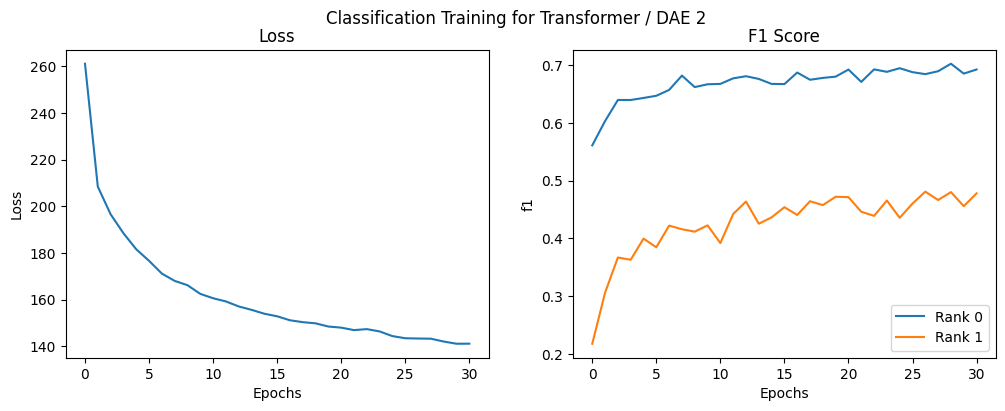

Test results: [0.70512, 0.47433]


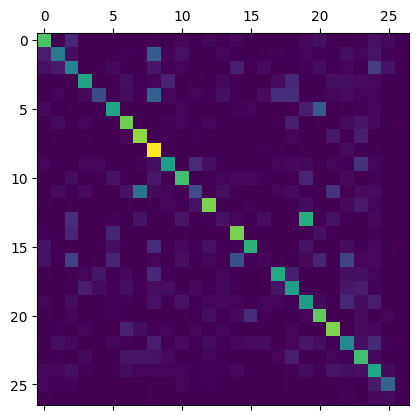

[[2620.   11.  413.    1.    0.    6.    4.    5.   20.    5.   76.   17.   84.    0.   77.   27.    4.    0.    0.   85.  163.   12.   11.   34.  162.   81.    0.]
 [ 289. 1481.  141.    6.    9.   27.   41.   24. 1026.   45.  169.    2.    5.   44.    9.   10.   28.   32.    5.   57.   42.   17.  130.   49.  188.   33.    0.]
 [ 159.  266. 1634.    0.    2.   80.    0.    0.  217.    3.   59.    4.    2.    0.  304.    2.  108.    7.    0.   40.  128.    0.   63.    2.  648.  180.    1.]
 [   4.   24.    1. 2151.   19.    0.  144.   27.   68.  347.    9.   24.    8.   72.    0.    0.    4.  110.  399.   17.    6.  128.  132.  102.  108.    5.    0.]
 [   6.   43.    1.   73.  809.    1.  125.   33. 1131.   65.   21.   49.   24.  144.    0.    8.  117.  458.  481.   27.   25.   56.  107.   53.   46.    6.    0.]
 [  80.    0.   17.    0.    8. 2123.    3.    0.    7.    0.   56.    0.    1.    0.   34.   66.   11.    0.    0.  310. 1061.    0.   27.   33.   72.    0.    0.]
 [   1.  1

NameError: name 'evaluate' is not defined

In [3]:
model = benchmark(
    hybrid.Classifier(LENGTH // 4, mapping, "cuda", hybrid.T_DAE_hybrid_2),
    "Transformer / DAE 2",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)
result = evaluate(model, test_data, "cuda", mapping, permute=False)
rounded_result = [float(f"{r:.5}") for r in result]

In [5]:
result = evaluate(model, test_data, "cuda", mapping, permute=False)
rounded_result = [float(f"{r:.5}") for r in result]

In [6]:
print(rounded_result)

[0.70726, 0.50088]


## 4. Adaptive Learning

In [2]:
from stelaro import models
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from stelaro.models import feedforward, autoencoder, transformer, hybrid
from time import time

LENGTH = 1500
BATCH_SIZE = 128
N_SAMPLE_BETWEEN_INTERVALS = 50_000

train_data = DataLoader(
    synthetic.AdaptiveCompressedReadDataset(
        "../data/version_1/compressed/train/",
        N_SAMPLE_BETWEEN_INTERVALS,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)
validate_data = DataLoader(
    synthetic.SyntheticReadDataset(
        "../data/version_1/compressed/validate/", 50_000, LENGTH, 2000
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_data = DataLoader(
    synthetic.SyntheticReadDataset(
        "../data/version_1/compressed/test/", 100_000, LENGTH, 2000
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

with open("../datasets/version_1_splits/map.json", "r") as f:
    mapping = json.load(f)


def benchmark(classifier: models.BaseClassifier, name: str, n_max_reads, patience=4):
    train_data.dataset.reset()
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=0.001)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1 = classifier.train_large_dataset_adaptive(
        train_data,
        validate_data,
        optimizer,
        evaluation_interval=N_SAMPLE_BETWEEN_INTERVALS,
        n_max_reads=n_max_reads,
        patience=patience,
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="losses")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Loss")
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping, permute=False)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test results: {rounded_result}")
    return classifier


from torch import no_grad, float32
import numpy as np


def confusion_matrix(classifier, loader, device, mapping) -> np.ndarray:
    """Returns: A confusion matrix with rows corresponding to true labels."""
    matrix = np.zeros((len(mapping), len(mapping)))
    with no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.type(float32).to(device)
            #x_batch = x_batch.permute(0, 2, 1)  # Swap channels and sequence.
            y_batch = y_batch.to("cpu")
            predictions = classifier.predict(x_batch)
            for y, p in zip(y_batch, predictions):
                matrix[y][p] += 1
    return matrix

In [3]:
from sklearn.metrics import precision_score


def rank_based_precision(
        mappings: dict, target: list[int], predictions: list[int]
        ) -> list[np.ndarray]:
    """Evaluate precision at multiple taxonomic ranks."""
    f = []
    for mapping in mappings:
        labels = list(set(mapping.values()))
        normalized_target = [mapping[int(v)] for v in list(target)]
        normalized_pred = [mapping[int(v)] for v in list(predictions)]
        f.append(
            precision_score(
                normalized_target,
                normalized_pred,
                average=None,
                labels=labels,
                zero_division=0.0
            )
        )
    return f


def evaluate(classifier, loader, device, mapping, permute=True):
    """Evaluate the F1 score at different taxonomic levels."""
    mappings = models.obtain_rank_based_mappings(mapping)
    ranks = []
    n_batches = 0
    with no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.type(float32).to(device)
            if permute:
                x_batch = x_batch.permute(0, 2, 1)  # Swap channels and sequence.
            y_batch = y_batch.to("cpu")
            predictions = classifier.predict(x_batch)
            ranks.append(rank_based_precision(mappings, y_batch, predictions))
            n_batches += 1
    collapsed_ranks = [np.zeros(len(r)) for r in ranks[0]]
    for rank in ranks:
        for i, result in enumerate(rank):
            collapsed_ranks[i] += result
    for i in range(len(collapsed_ranks)):
        collapsed_ranks[i] = np.mean(collapsed_ranks[i])
        collapsed_ranks[i] /= n_batches
    collapsed_ranks = [r for r in reversed(collapsed_ranks)]
    for i in range(len(collapsed_ranks) - 1):
        assert collapsed_ranks[i] > collapsed_ranks[i + 1]
    return collapsed_ranks

### 4.1. Transformer

Number of parameters: 480_795


  1%|          | 390/68609 [00:57<2:39:13,  7.14it/s]

N Reads: 50_048 Loss: 934.67. F1: [0.56252, 0.24732]. Patience: 20


  1%|          | 392/68609 [01:29<128:25:16,  6.78s/it]

F1 scores: [0.37112206 0.15396763 0.35220994 0.25797101 0.31986626 0.38535645
 0.59642067 0.43691787 0.45065789 0.10437956 0.05409253 0.20253834
 0.3462843  0.10199715 0.50740192 0.28837877 0.28802993 0.11627228
 0.17204819 0.12698413 0.25065963 0.4040404  0.01363858 0.32216851
 0.08185654 0.47088608 0.02620087]
Setting distributions: [0.03480683 0.03944711 0.03521096 0.03722471 0.03590209 0.03450266
 0.02999252 0.03340087 0.03310726 0.04050674 0.04158131 0.03840923
 0.03533758 0.04055765 0.03189472 0.03657494 0.03658239 0.04025261
 0.03906076 0.04002371 0.03738094 0.03410341 0.04244575 0.0358529
 0.04098803 0.03267501 0.04217731]


  1%|          | 781/68609 [02:24<2:40:34,  7.04it/s]  

N Reads: 100_096 Loss: 734.56. F1: [0.60161, 0.31511]. Patience: 20


  1%|          | 783/68609 [02:56<126:25:54,  6.71s/it]

F1 scores: [0.45279188 0.17860082 0.39039666 0.3089326  0.3639576  0.44193346
 0.65876035 0.51197605 0.45096731 0.18562092 0.2150134  0.38633377
 0.56645649 0.11679293 0.48546042 0.32377668 0.35622205 0.22090963
 0.12314842 0.39130435 0.43717472 0.45083014 0.11620246 0.30619152
 0.10500808 0.49089166 0.15741391]
Setting distributions: [0.03453055 0.04064994 0.03592309 0.0377412  0.03651315 0.03477289
 0.02993375 0.03320968 0.03457127 0.04049327 0.03983729 0.03601376
 0.03199379 0.04202937 0.03380146 0.03740991 0.0366858  0.0397057
 0.04188753 0.03590283 0.0348791  0.03457433 0.04204255 0.03780238
 0.04229238 0.03368024 0.04112279]


  2%|▏         | 1172/68609 [03:53<12:04:01,  1.55it/s]

N Reads: 150_144 Loss: 669.28. F1: [0.63267, 0.33476]. Patience: 20


  2%|▏         | 1174/68609 [04:24<126:56:48,  6.78s/it]

F1 scores: [0.55092091 0.17820946 0.4595066  0.27405081 0.38776262 0.49415615
 0.71021061 0.52447771 0.42385009 0.16612165 0.16554054 0.46885418
 0.60575139 0.06845361 0.50728363 0.35661671 0.10324349 0.24656734
 0.12785714 0.44475395 0.47285068 0.51626729 0.16061925 0.27552488
 0.26505276 0.55687139 0.1770972 ]
Setting distributions: [0.03270208 0.04111324 0.03476507 0.03895034 0.03638415 0.03398312
 0.02910731 0.03329884 0.03556975 0.04138603 0.04139915 0.03455412
 0.03146469 0.04359016 0.03368686 0.03708704 0.04280504 0.03957058
 0.04224957 0.035098   0.03446393 0.03348412 0.04151021 0.03891708
 0.03915341 0.03256779 0.04113834]


  2%|▏         | 1563/68609 [05:21<10:07:03,  1.84it/s] 

N Reads: 200_192 Loss: 630.20. F1: [0.62679, 0.3425]. Patience: 20


  2%|▏         | 1565/68609 [05:51<123:26:38,  6.63s/it]

F1 scores: [0.54581006 0.25186766 0.40952546 0.36026332 0.43570348 0.53449834
 0.59109462 0.48268398 0.51503079 0.26809211 0.26280624 0.55007474
 0.62708804 0.11023622 0.51199452 0.23232576 0.07307979 0.2636833
 0.11101217 0.42481105 0.4525974  0.4776824  0.22083426 0.35351882
 0.25512784 0.50377488 0.17355372]
Setting distributions: [0.03304885 0.03972917 0.03614614 0.0372657  0.0355512  0.03330593
 0.03201968 0.03448349 0.03374836 0.03936044 0.03948057 0.03295193
 0.03120167 0.04294798 0.03381736 0.04017329 0.04379242 0.03946064
 0.04293034 0.03579875 0.03516726 0.03459716 0.04043446 0.03741898
 0.03965508 0.03400417 0.04150898]


  3%|▎         | 1954/68609 [06:49<10:59:17,  1.69it/s] 

N Reads: 250_240 Loss: 603.12. F1: [0.65704, 0.37153]. Patience: 20


  3%|▎         | 1956/68609 [07:20<126:46:18,  6.85s/it]

F1 scores: [0.56409037 0.18663503 0.4874498  0.41220423 0.42195846 0.39869043
 0.69380117 0.58708892 0.47006369 0.28231644 0.20706371 0.55679934
 0.64960536 0.1931876  0.53309481 0.39711695 0.2154617  0.28884181
 0.23019355 0.49151172 0.45242626 0.49410099 0.22836096 0.26257953
 0.32426886 0.5630363  0.19456366]
Setting distributions: [0.03322827 0.04196294 0.03500181 0.03674306 0.03651734 0.03705578
 0.03022665 0.03269607 0.03540414 0.03974878 0.0414902  0.033397
 0.03124938 0.04181131 0.03394554 0.03709219 0.04129586 0.03959778
 0.04095495 0.03490781 0.03581228 0.03484789 0.04099736 0.04020551
 0.03877797 0.03325267 0.04177946]


  3%|▎         | 2345/68609 [08:18<8:35:46,  2.14it/s]  

N Reads: 300_288 Loss: 578.50. F1: [0.65354, 0.38374]. Patience: 20


  3%|▎         | 2347/68609 [08:49<123:25:42,  6.71s/it]

F1 scores: [0.55643163 0.20263263 0.47360775 0.44934102 0.43700397 0.42638146
 0.72386484 0.54953979 0.51345756 0.35741669 0.32595089 0.58613445
 0.66248548 0.18835246 0.58629572 0.18158403 0.19376147 0.25865082
 0.20465116 0.48511384 0.44584781 0.51300933 0.27631579 0.31742467
 0.3499275  0.62044016 0.21155411]
Setting distributions: [0.0336474  0.04189392 0.0355779  0.03614352 0.03643108 0.03667867
 0.02974478 0.03380804 0.03464906 0.03828614 0.03901956 0.03295507
 0.03117544 0.04222677 0.03295131 0.04238453 0.04210069 0.04058822
 0.04184687 0.03530971 0.03622494 0.03465951 0.04017648 0.03921829
 0.0384607  0.03215546 0.04168597]


  4%|▍         | 2736/68609 [09:47<9:34:25,  1.91it/s]  

N Reads: 350_336 Loss: 557.59. F1: [0.63646, 0.38858]. Patience: 20


  4%|▍         | 2738/68609 [10:18<123:53:30,  6.77s/it]

F1 scores: [0.59284497 0.19444444 0.34493547 0.46218842 0.45666149 0.54070291
 0.6825099  0.43037975 0.56288715 0.45027705 0.28617536 0.64329795
 0.65502909 0.15622983 0.64603393 0.32247481 0.33400518 0.27680053
 0.15928067 0.44261967 0.46499339 0.4754522  0.29230504 0.40224772
 0.32839989 0.49805172 0.14364641]
Setting distributions: [0.03291196 0.04223015 0.03871032 0.03596789 0.03609716 0.03413151
 0.03081479 0.03671186 0.03361265 0.03624648 0.04008466 0.03173192
 0.03145754 0.04312396 0.03166792 0.03923565 0.03896597 0.04030393
 0.0430526  0.03642558 0.03590228 0.03565766 0.03994129 0.03736984
 0.03909707 0.03512908 0.04341827]


  5%|▍         | 3127/68609 [11:16<10:57:56,  1.66it/s] 

N Reads: 400_384 Loss: 541.36. F1: [0.63968, 0.4094]. Patience: 20


  5%|▍         | 3129/68609 [11:47<123:32:32,  6.79s/it]

F1 scores: [0.54641509 0.16704981 0.48041349 0.42635659 0.48819346 0.50833333
 0.64875783 0.6333964  0.5623328  0.42665923 0.28945171 0.63406645
 0.67781441 0.20984316 0.63941203 0.35187225 0.41452488 0.1977066
 0.27997094 0.52586976 0.500656   0.50700117 0.26169355 0.37142107
 0.28598425 0.5889926  0.23439001]
Setting distributions: [0.03449302 0.04349522 0.03605921 0.03734196 0.0358746  0.03539669
 0.03206447 0.03242899 0.0341153  0.03733478 0.04059066 0.03241309
 0.03137496 0.04247975 0.03228624 0.03910945 0.03762273 0.04276774
 0.04081564 0.03498055 0.03557887 0.0354283  0.04124936 0.03864556
 0.04067295 0.03348267 0.04189726]


  5%|▌         | 3518/68609 [12:45<6:19:25,  2.86it/s]  

N Reads: 450_432 Loss: 526.92. F1: [0.65215, 0.39005]. Patience: 19


  5%|▌         | 3520/68609 [13:16<119:39:20,  6.62s/it]

F1 scores: [0.54376838 0.18802698 0.48138298 0.3370333  0.39579297 0.50625711
 0.6519337  0.57931034 0.54062038 0.3061437  0.26865672 0.63620899
 0.67075979 0.15333535 0.53436773 0.40225757 0.30186335 0.29483
 0.33681672 0.50857569 0.514068   0.45125832 0.25770021 0.37333333
 0.39548577 0.53043478 0.14214123]
Setting distributions: [0.03410567 0.04243731 0.03556677 0.03894751 0.03757133 0.03498421
 0.03157239 0.03327326 0.0341794  0.03967096 0.04054893 0.03194067
 0.03113147 0.04324981 0.03432584 0.03741993 0.03977121 0.03993593
 0.03895258 0.0349299  0.03480127 0.0362723  0.04080553 0.03809735
 0.03757853 0.03441795 0.04351198]


  6%|▌         | 3909/68609 [14:14<6:02:09,  2.98it/s]  

N Reads: 500_480 Loss: 514.41. F1: [0.66008, 0.42781]. Patience: 19


  6%|▌         | 3911/68609 [14:45<119:58:07,  6.68s/it]

F1 scores: [0.60515021 0.19582665 0.49358526 0.40947721 0.43962692 0.57295597
 0.73338168 0.57766687 0.57550051 0.41727367 0.42161254 0.62598814
 0.68843188 0.1837903  0.67613492 0.43254377 0.35604396 0.39351236
 0.29092752 0.4967524  0.51013699 0.47993944 0.26783479 0.34745266
 0.30827068 0.669924   0.14206128]
Setting distributions: [0.03345911 0.0432778  0.03613528 0.03815283 0.03742961 0.03423137
 0.03038314 0.03411836 0.03417033 0.03796581 0.03786173 0.03295925
 0.03146138 0.04356652 0.03175635 0.03759952 0.03943457 0.03853579
 0.04099656 0.03605931 0.03573825 0.03646261 0.04155049 0.03964065
 0.04058053 0.03190534 0.0445675 ]


  6%|▋         | 4300/68609 [15:43<4:56:18,  3.62it/s]  

N Reads: 550_528 Loss: 498.15. F1: [0.67575, 0.42103]. Patience: 18


  6%|▋         | 4302/68609 [16:13<118:26:50,  6.63s/it]

F1 scores: [0.57804014 0.2559775  0.51633795 0.42685327 0.45676919 0.55876393
 0.73866199 0.59878214 0.57520564 0.38954057 0.36740529 0.63742318
 0.67738791 0.2608931  0.62807416 0.35748503 0.28374456 0.342723
 0.22739643 0.48375587 0.54518371 0.47823721 0.24426403 0.32323804
 0.4127075  0.60741206 0.17852523]
Setting distributions: [0.03397818 0.04167396 0.03545257 0.03759083 0.03687598 0.03443879
 0.03014007 0.03348254 0.03404591 0.03848243 0.03901136 0.0325592
 0.03160423 0.0415565  0.0327826  0.03924841 0.04101046 0.03960115
 0.04235692 0.03623113 0.03476329 0.036363   0.04195386 0.04006675
 0.03792885 0.03327632 0.04352471]


  7%|▋         | 4691/68609 [17:12<5:09:35,  3.44it/s]  

N Reads: 600_576 Loss: 487.12. F1: [0.66684, 0.42095]. Patience: 17


  7%|▋         | 4693/68609 [17:43<119:56:31,  6.76s/it]

F1 scores: [0.61566772 0.24931399 0.52841476 0.47406225 0.44627275 0.56254093
 0.70058294 0.56573427 0.47439505 0.49074593 0.24124514 0.62392673
 0.69880885 0.19325301 0.68418803 0.32593037 0.31845043 0.31232028
 0.36734694 0.46486701 0.54703593 0.51518168 0.23751846 0.33846918
 0.33384758 0.65676152 0.16802974]
Setting distributions: [0.03306651 0.04181732 0.03515065 0.03644893 0.03711272 0.03433551
 0.0310382  0.03425923 0.03644098 0.03605042 0.04201006 0.03286923
 0.03108058 0.04315641 0.03142981 0.03998725 0.04016591 0.04031234
 0.03899796 0.03666857 0.03470586 0.03546674 0.04209908 0.03968774
 0.03979813 0.03208493 0.0437589 ]


  7%|▋         | 5082/68609 [18:41<4:58:34,  3.55it/s]  

N Reads: 650_624 Loss: 473.34. F1: [0.6387, 0.42]. Patience: 16


  7%|▋         | 5084/68609 [19:12<116:48:47,  6.62s/it]

F1 scores: [0.53999116 0.21866485 0.46291426 0.51618958 0.46744345 0.51876453
 0.72235753 0.56738988 0.50328688 0.4685454  0.3561095  0.60192476
 0.69983598 0.16991576 0.73761261 0.35181872 0.26229508 0.30973745
 0.3853211  0.48317631 0.55207086 0.47246572 0.25       0.37126981
 0.36205502 0.57594324 0.20578778]
Setting distributions: [0.03487245 0.04254736 0.03671344 0.03544095 0.03660526 0.03537945
 0.03051661 0.03421803 0.03574914 0.03657894 0.03926448 0.03339316
 0.03105454 0.04371174 0.03015224 0.03936697 0.04150525 0.04037208
 0.03856676 0.03622948 0.03458393 0.0364853  0.04179892 0.03890238
 0.03912247 0.03401373 0.04285493]


  8%|▊         | 5473/68609 [20:10<4:18:27,  4.07it/s]  

N Reads: 700_672 Loss: 466.01. F1: [0.67001, 0.43343]. Patience: 16


  8%|▊         | 5475/68609 [20:42<118:13:38,  6.74s/it]

F1 scores: [0.56833713 0.22979073 0.58320043 0.50597045 0.48076923 0.35588972
 0.72493915 0.58749394 0.56469735 0.29577465 0.45696721 0.5945433
 0.6908642  0.25859459 0.74135756 0.44287516 0.36652482 0.36521739
 0.35258641 0.48439094 0.54075372 0.55509528 0.25701706 0.28966914
 0.40619705 0.59653624 0.26260704]
Setting distributions: [0.03454673 0.04271602 0.03418807 0.03605167 0.03665979 0.03967319
 0.03076785 0.03408447 0.03463456 0.0411238  0.03723414 0.03391436
 0.03159009 0.04202097 0.03037166 0.03757419 0.03941656 0.03944811
 0.0397529  0.03657239 0.03521233 0.03486626 0.04205904 0.04127113
 0.03845925 0.03386627 0.04192415]


  9%|▊         | 5864/68609 [21:41<4:39:26,  3.74it/s]  

N Reads: 750_720 Loss: 454.64. F1: [0.67159, 0.43861]. Patience: 16


  9%|▊         | 5866/68609 [22:13<119:36:05,  6.86s/it]

F1 scores: [0.54484754 0.25467022 0.54917812 0.47819149 0.47924788 0.52003787
 0.7592544  0.58048    0.55980472 0.38752363 0.41487603 0.52436592
 0.72874706 0.20663034 0.71195366 0.3420988  0.40823529 0.35481928
 0.36585366 0.55620723 0.51326602 0.48983087 0.30354853 0.39073806
 0.39039666 0.61552567 0.21251071]
Setting distributions: [0.03518502 0.04220139 0.03508031 0.03679674 0.03677119 0.03578491
 0.03000074 0.03432344 0.03482336 0.03898905 0.03832768 0.03568026
 0.0307384  0.04336298 0.03114446 0.0400874  0.03848825 0.03977983
 0.03951302 0.03491035 0.03594865 0.0365153  0.04101953 0.03891133
 0.03891958 0.03347605 0.04322079]


  9%|▉         | 6255/68609 [23:12<5:00:02,  3.46it/s]  

N Reads: 800_768 Loss: 450.90. F1: [0.68022, 0.46656]. Patience: 16


  9%|▉         | 6257/68609 [23:44<117:11:52,  6.77s/it]

F1 scores: [0.60531258 0.23990773 0.56625892 0.48279378 0.46854857 0.62366658
 0.72770398 0.64563797 0.57483984 0.54912517 0.40553846 0.66448032
 0.71120807 0.27005131 0.68877663 0.50882709 0.45088339 0.33793103
 0.35502249 0.55857143 0.53949621 0.48486563 0.27481772 0.37405732
 0.4429317  0.66399313 0.18234027]
Setting distributions: [0.03434987 0.04334945 0.03531172 0.03736739 0.03771824 0.03389782
 0.03133548 0.03335669 0.03510038 0.03573371 0.03927012 0.03289262
 0.03174176 0.04260704 0.03229422 0.03672621 0.03815331 0.04093523
 0.04051428 0.03550106 0.03597086 0.03731636 0.04248965 0.04004547
 0.03834916 0.03290462 0.04476728]


 10%|▉         | 6646/68609 [24:43<3:48:03,  4.53it/s]  

N Reads: 850_816 Loss: 439.39. F1: [0.67703, 0.44158]. Patience: 15


 10%|▉         | 6648/68609 [25:14<114:51:45,  6.67s/it]

F1 scores: [0.60514687 0.23469786 0.52605595 0.52964427 0.52567817 0.57439825
 0.70282723 0.61694719 0.55842881 0.48165375 0.41796875 0.53469641
 0.66834747 0.23596491 0.68999114 0.37288136 0.30229508 0.38337182
 0.38046735 0.48142354 0.55503237 0.45756634 0.26251277 0.36114222
 0.41987637 0.64918415 0.21953676]
Setting distributions: [0.03381277 0.04279286 0.03573002 0.03564303 0.03573917 0.03455815
 0.03144489 0.03352671 0.03494526 0.03680637 0.03835017 0.03552056
 0.03228071 0.04276214 0.03175605 0.03944314 0.04115423 0.03918884
 0.03925924 0.03681196 0.0350276  0.03739028 0.04211859 0.03972771
 0.03830393 0.03274525 0.04316038]


 10%|█         | 7037/68609 [26:12<3:54:42,  4.37it/s]  

N Reads: 900_864 Loss: 434.51. F1: [0.67253, 0.45118]. Patience: 14


 10%|█         | 7039/68609 [26:44<115:51:11,  6.77s/it]

F1 scores: [0.55515152 0.21187139 0.52451325 0.45362392 0.52145215 0.61119516
 0.72023937 0.64102564 0.5553576  0.44770206 0.48227659 0.66350975
 0.70444942 0.25610902 0.763827   0.45915735 0.24921025 0.33565107
 0.30352861 0.5078453  0.60242108 0.51819292 0.31506513 0.29383886
 0.40476883 0.66685129 0.2212693 ]
Setting distributions: [0.0352317  0.04360237 0.0359788  0.03770739 0.03605344 0.03386511
 0.03120614 0.03313772 0.03522668 0.03785179 0.03700871 0.03258946
 0.03159117 0.04252366 0.03014329 0.03757246 0.04269188 0.04058408
 0.04136737 0.03638523 0.03407907 0.03613291 0.04108606 0.04160364
 0.03889869 0.03250798 0.04337321]


 11%|█         | 7428/68609 [27:43<3:30:20,  4.85it/s]  

N Reads: 950_912 Loss: 427.99. F1: [0.68195, 0.45438]. Patience: 13


 11%|█         | 7430/68609 [28:15<115:20:35,  6.79s/it]

F1 scores: [0.58187391 0.22516056 0.53770919 0.52227614 0.48509174 0.5187801
 0.79066265 0.53001464 0.52668276 0.49094123 0.41451659 0.6834817
 0.71284501 0.2198108  0.71767688 0.39617084 0.4529703  0.3968254
 0.34407428 0.49012027 0.52732766 0.48576214 0.33781764 0.36462779
 0.43737166 0.67292912 0.22692308]
Setting distributions: [0.03466491 0.04338447 0.03574448 0.03612173 0.03703067 0.03620719
 0.02956124 0.03593257 0.03601401 0.03688768 0.03875582 0.03218119
 0.03146343 0.04351524 0.03134532 0.03920427 0.03781585 0.03918827
 0.04047772 0.03690775 0.03599825 0.03701428 0.04063066 0.03997531
 0.03819715 0.03243914 0.04334139]


 11%|█▏        | 7819/68609 [29:14<3:40:14,  4.60it/s]  

N Reads: 1_000_960 Loss: 428.08. F1: [0.67848, 0.44213]. Patience: 12


 11%|█▏        | 7821/68609 [29:46<114:59:07,  6.81s/it]

F1 scores: [0.58046768 0.2483559  0.5415275  0.54297648 0.47852437 0.46446787
 0.7826087  0.58555589 0.48982316 0.30977664 0.47420918 0.64034422
 0.71747388 0.25859976 0.76233184 0.34332989 0.25887124 0.32942556
 0.39476507 0.52428765 0.58203531 0.50523969 0.28606012 0.37437437
 0.3947203  0.67955644 0.19047619]
Setting distributions: [0.03440472 0.042454   0.0353485  0.03531338 0.03687548 0.03721617
 0.0295055  0.0342814  0.03660164 0.04096536 0.03698007 0.03295351
 0.03108415 0.04220572 0.02999694 0.04015215 0.04219914 0.04048914
 0.03890553 0.03576633 0.03436672 0.03622799 0.04154017 0.03939973
 0.03890661 0.03200314 0.04385681]


 12%|█▏        | 8210/68609 [30:46<3:26:20,  4.88it/s]  

N Reads: 1_051_008 Loss: 418.57. F1: [0.68244, 0.45101]. Patience: 11


 12%|█▏        | 8212/68609 [31:18<114:35:44,  6.83s/it]

F1 scores: [0.60907018 0.22538375 0.53986755 0.49534717 0.43291995 0.53636364
 0.77381534 0.64701319 0.5613155  0.46842428 0.434038   0.65760143
 0.71027604 0.2110853  0.71144591 0.42191083 0.4001113  0.34155496
 0.364765   0.55715018 0.54165689 0.48707483 0.28038278 0.27726322
 0.38016529 0.68629011 0.25925926]
Setting distributions: [0.03393468 0.04329552 0.03562302 0.03670919 0.03823224 0.03570851
 0.02991537 0.03300898 0.03509976 0.03736603 0.03820496 0.03275066
 0.03146555 0.04364436 0.03143701 0.03850083 0.03903267 0.04046128
 0.03989502 0.03520138 0.03557937 0.03691101 0.0419537  0.04202981
 0.0395193  0.03205074 0.04246906]


 13%|█▎        | 8601/68609 [32:18<3:18:00,  5.05it/s]  

N Reads: 1_101_056 Loss: 416.63. F1: [0.66966, 0.451]. Patience: 10


 13%|█▎        | 8603/68609 [32:50<113:42:52,  6.82s/it]

F1 scores: [0.54993895 0.30730479 0.53608801 0.48328109 0.49848332 0.63002763
 0.73425499 0.58913502 0.51538207 0.46375238 0.37293233 0.63338701
 0.68428868 0.23570363 0.69745031 0.40636805 0.35305283 0.34419141
 0.40415704 0.53042198 0.61835749 0.52814371 0.28010899 0.39707602
 0.37041565 0.65680056 0.15727003]
Setting distributions: [0.03534818 0.04126288 0.03568583 0.0369731  0.03660252 0.03339586
 0.0308551  0.0343927  0.03619057 0.03744915 0.03966308 0.03331396
 0.03207313 0.0430083  0.03175229 0.03884801 0.04014768 0.04036369
 0.03890191 0.03582395 0.03368034 0.03587948 0.04192583 0.03907452
 0.03972443 0.03274321 0.04492028]


 13%|█▎        | 8992/68609 [33:49<3:06:41,  5.32it/s]  

N Reads: 1_151_104 Loss: 413.40. F1: [0.68085, 0.46632]. Patience: 9


 13%|█▎        | 8994/68609 [34:21<111:37:55,  6.74s/it]

F1 scores: [0.54862727 0.22169249 0.53373894 0.51451541 0.49262381 0.64506881
 0.74476987 0.63061466 0.55910224 0.45460277 0.51576073 0.66913651
 0.72625981 0.18616527 0.78576993 0.36909449 0.33988764 0.39093625
 0.40819585 0.5221957  0.59652174 0.51702128 0.31451069 0.40563752
 0.40354913 0.66760563 0.22462203]
Setting distributions: [0.03573773 0.04378798 0.03610433 0.03657768 0.03711673 0.03336301
 0.03090804 0.03371892 0.0354798  0.03805294 0.03654702 0.03277039
 0.03136382 0.04466278 0.02989847 0.04015844 0.04087761 0.03962062
 0.03919563 0.03638857 0.03455841 0.03651598 0.04150248 0.03925863
 0.03931005 0.03280808 0.04371584]


 14%|█▎        | 9383/68609 [35:20<2:56:49,  5.58it/s]  

N Reads: 1_201_152 Loss: 408.24. F1: [0.68607, 0.46105]. Patience: 8


 14%|█▎        | 9385/68609 [35:52<112:09:16,  6.82s/it]

F1 scores: [0.5830736  0.26262626 0.56353839 0.50644884 0.53648463 0.6626005
 0.81263499 0.58998733 0.53027926 0.48064593 0.44331856 0.63084112
 0.73230309 0.2145982  0.75683212 0.33290653 0.2943072  0.38076817
 0.40401846 0.47872798 0.64423311 0.52040816 0.31255374 0.30619469
 0.43007186 0.62649049 0.2585034 ]
Setting distributions: [0.03480998 0.04268249 0.03528991 0.03669244 0.03595454 0.03285622
 0.02917029 0.03464013 0.03610699 0.03732635 0.03824338 0.03363646
 0.03114382 0.0438624  0.03054121 0.0409559  0.04190417 0.03978007
 0.03920887 0.03737346 0.03330746 0.0363495  0.04145591 0.04161213
 0.03856881 0.03374335 0.04278378]


 14%|█▍        | 9774/68609 [36:50<2:44:35,  5.96it/s]  

N Reads: 1_251_200 Loss: 399.99. F1: [0.68985, 0.44989]. Patience: 7


 14%|█▍        | 9776/68609 [37:22<110:15:17,  6.75s/it]

F1 scores: [0.59309697 0.29977957 0.47286338 0.45398773 0.46931408 0.63218723
 0.78887155 0.65932154 0.54676692 0.43114002 0.46947368 0.70550639
 0.68236819 0.19538968 0.76152103 0.28084569 0.42626796 0.39319108
 0.33680227 0.44921487 0.55713916 0.42191471 0.22957662 0.34996349
 0.468258   0.66472812 0.26146789]
Setting distributions: [0.03431551 0.04146976 0.0372481  0.0377085  0.03733468 0.03336207
 0.02954041 0.03270024 0.03544554 0.03826577 0.03733078 0.03157375
 0.03213811 0.04401591 0.03020751 0.04193157 0.03838461 0.03919138
 0.04056675 0.03782491 0.03519255 0.03849078 0.04318207 0.04024573
 0.03736043 0.03256837 0.04240421]


 15%|█▍        | 10165/68609 [38:22<2:47:24,  5.82it/s] 

N Reads: 1_301_248 Loss: 399.75. F1: [0.66171, 0.44241]. Patience: 6


 15%|█▍        | 10167/68609 [38:54<109:44:10,  6.76s/it]

F1 scores: [0.55632884 0.22286184 0.53664755 0.53488372 0.52057511 0.52435724
 0.70312181 0.56811798 0.55876923 0.40724206 0.39210611 0.68438859
 0.71007836 0.25786315 0.73321599 0.36211232 0.33305109 0.34206374
 0.39420756 0.42128902 0.59383108 0.51421298 0.29271954 0.3532839
 0.40200825 0.66363084 0.1776435 ]
Setting distributions: [0.03500709 0.04309322 0.03548434 0.03552711 0.03587407 0.03578236
 0.03144756 0.03472122 0.03494792 0.03862225 0.03898928 0.03190182
 0.03127887 0.04224449 0.03071782 0.03971658 0.04042128 0.04020274
 0.03893832 0.03828163 0.03409772 0.03602835 0.04139927 0.03993066
 0.03874916 0.03240516 0.04418971]


 15%|█▌        | 10556/68609 [39:53<2:42:08,  5.97it/s]  

N Reads: 1_351_296 Loss: 397.37. F1: [0.68927, 0.47786]. Patience: 6


 15%|█▌        | 10558/68609 [40:25<110:11:20,  6.83s/it]

F1 scores: [0.58975586 0.24734147 0.57109214 0.55058125 0.53792704 0.54370797
 0.73825503 0.64269435 0.56513531 0.50627005 0.51222651 0.62965186
 0.72718351 0.28429074 0.76412121 0.47148988 0.39079169 0.3556556
 0.40629238 0.55735462 0.60345178 0.53613281 0.30889935 0.35093615
 0.46027268 0.66648634 0.21324503]
Setting distributions: [0.0350208  0.04352403 0.03548428 0.03599363 0.03630787 0.03616432
 0.0313331  0.03370617 0.03563221 0.03709402 0.0369461  0.03403006
 0.03160804 0.04260646 0.03069076 0.03795772 0.03996171 0.04083425
 0.03957678 0.03582543 0.03468069 0.03635243 0.04199535 0.04095145
 0.03823628 0.03311534 0.04437075]


 16%|█▌        | 10947/68609 [41:24<2:38:12,  6.07it/s]  

N Reads: 1_401_344 Loss: 386.00. F1: [0.68334, 0.47256]. Patience: 5


 16%|█▌        | 10949/68609 [41:56<108:50:12,  6.80s/it]

F1 scores: [0.60453887 0.23425592 0.54601665 0.52504638 0.49185668 0.55374593
 0.78296774 0.60091884 0.5502379  0.51659145 0.48180611 0.67975831
 0.73435034 0.3282588  0.76217361 0.38079561 0.45970859 0.35202576
 0.36476346 0.52252671 0.54007147 0.50830798 0.33242236 0.37770563
 0.42828729 0.69165338 0.23422053]
Setting distributions: [0.03452831 0.04369033 0.03597634 0.03649521 0.03731644 0.03578509
 0.03011339 0.03461788 0.03587189 0.03670442 0.03756512 0.03266713
 0.03131634 0.04136439 0.0306279  0.04006445 0.03811189 0.04077631
 0.04046114 0.03655756 0.03612344 0.03690938 0.04126137 0.04014091
 0.03888935 0.03237281 0.0436912 ]


 17%|█▋        | 11338/68609 [42:55<2:31:52,  6.28it/s]  

N Reads: 1_451_392 Loss: 384.22. F1: [0.69854, 0.47876]. Patience: 5


 17%|█▋        | 11340/68609 [43:26<105:15:52,  6.62s/it]

F1 scores: [0.61683122 0.23399746 0.6015625  0.54504706 0.46064942 0.61018923
 0.77825388 0.65057258 0.58627859 0.3987509  0.49933528 0.70235756
 0.69396552 0.2        0.75017527 0.48377254 0.47196516 0.39452055
 0.35827443 0.52946823 0.65936535 0.5494186  0.29766369 0.38651163
 0.45934009 0.63573668 0.20387097]
Setting distributions: [0.03437117 0.04388442 0.03475059 0.03615497 0.03825222 0.03453622
 0.03035988 0.03353271 0.03513039 0.03979037 0.03729089 0.03224587
 0.03245441 0.04472925 0.03105762 0.03767762 0.03797103 0.03989549
 0.04079619 0.0365421  0.03331421 0.03604634 0.04230235 0.04009451
 0.03828475 0.03390137 0.04463306]


 17%|█▋        | 11729/68609 [44:24<2:25:44,  6.50it/s]  

N Reads: 1_501_440 Loss: 388.07. F1: [0.69424, 0.46372]. Patience: 4


 17%|█▋        | 11731/68609 [44:55<103:46:47,  6.57s/it]

F1 scores: [0.54056418 0.24800304 0.55433699 0.48312958 0.52156057 0.54033042
 0.78863329 0.62580645 0.5525787  0.47350993 0.44177396 0.56417391
 0.74054199 0.37015391 0.69628703 0.51519086 0.31796927 0.29622332
 0.33310153 0.48666949 0.59806419 0.56127451 0.30982019 0.39634801
 0.48567376 0.68988822 0.20327422]
Setting distributions: [0.03588913 0.04308353 0.03555044 0.03730151 0.03635645 0.03589488
 0.02978884 0.03379293 0.03559368 0.03753807 0.03831849 0.03530854
 0.03097146 0.04007971 0.03205974 0.03651309 0.04136299 0.04189774
 0.04099087 0.03721446 0.03447514 0.03537984 0.04156338 0.03943557
 0.03723895 0.03221709 0.04418346]


 18%|█▊        | 12120/68609 [45:54<2:29:08,  6.31it/s]  

N Reads: 1_551_488 Loss: 385.83. F1: [0.68724, 0.477]. Patience: 3


 18%|█▊        | 12122/68609 [46:26<106:18:32,  6.78s/it]

F1 scores: [0.59581472 0.2745098  0.56223849 0.52517162 0.52027748 0.61112898
 0.77324633 0.59033253 0.57620818 0.57444668 0.44189556 0.68533333
 0.73957845 0.20110755 0.75172907 0.42712355 0.41365576 0.37849204
 0.42208135 0.53523903 0.59899284 0.52210088 0.32149901 0.34926151
 0.40518556 0.68324022 0.24371668]
Setting distributions: [0.03486373 0.04284123 0.03569738 0.03661769 0.0367392  0.0344835
 0.03045838 0.03499984 0.03535053 0.03539427 0.0386853  0.03264112
 0.0312943  0.04466369 0.03099262 0.03905207 0.03938645 0.04025951
 0.03917726 0.03636773 0.03478482 0.03669393 0.04167456 0.04098526
 0.03959675 0.03269309 0.04360578]


 18%|█▊        | 12511/68609 [47:25<2:26:12,  6.39it/s]  

N Reads: 1_601_536 Loss: 376.88. F1: [0.70178, 0.47211]. Patience: 2


 18%|█▊        | 12513/68609 [47:56<105:05:50,  6.74s/it]

F1 scores: [0.63319721 0.26617827 0.53125    0.57820359 0.55359917 0.48075527
 0.73633518 0.61835749 0.58278146 0.5022508  0.50225338 0.6835443
 0.72360999 0.21155217 0.7232865  0.38129282 0.34519573 0.35190983
 0.4814571  0.56305673 0.62755924 0.50476644 0.29681112 0.33570282
 0.44594595 0.69457197 0.20854922]
Setting distributions: [0.03380161 0.04287814 0.03632281 0.03516163 0.0357701  0.03757156
 0.03125096 0.0341686  0.03504841 0.03703997 0.03703991 0.03255651
 0.03156566 0.04422907 0.03157366 0.04003131 0.04092401 0.04075797
 0.03755421 0.03553621 0.03394104 0.03697776 0.04212058 0.04115877
 0.03843241 0.03228379 0.04430333]


 19%|█▉        | 12902/68609 [48:55<2:22:44,  6.50it/s]  

N Reads: 1_651_584 Loss: 376.45. F1: [0.68815, 0.48473]. Patience: 2


 19%|█▉        | 12904/68609 [49:27<104:01:18,  6.72s/it]

F1 scores: [0.60841899 0.22799189 0.5692793  0.53245033 0.51515152 0.64824242
 0.78826859 0.63325183 0.58277725 0.50695971 0.47162599 0.71808949
 0.72744676 0.2558538  0.74885845 0.51727982 0.43422819 0.39324287
 0.39710387 0.45682749 0.60179641 0.54426966 0.32323232 0.40133939
 0.44158416 0.67949394 0.2029703 ]
Setting distributions: [0.03472705 0.04422064 0.03570378 0.03662285 0.03705455 0.03373325
 0.03023888 0.03410734 0.03536694 0.03725897 0.03814073 0.03199021
 0.0317567  0.04352535 0.03122237 0.03700143 0.039074   0.04009679
 0.04000044 0.03851003 0.03489231 0.0363279  0.04184391 0.03989474
 0.03889043 0.03295336 0.04484506]


 19%|█▉        | 13293/68609 [50:26<2:21:54,  6.50it/s]  

N Reads: 1_701_632 Loss: 372.95. F1: [0.67981, 0.4697]. Patience: 1


 19%|█▉        | 13295/68609 [50:57<103:34:08,  6.74s/it]

F1 scores: [0.63599799 0.23003195 0.5412844  0.52591257 0.50406504 0.53890984
 0.76960193 0.65370317 0.56575964 0.53379751 0.53918952 0.67052605
 0.74228356 0.21636686 0.7607998  0.32733945 0.27334852 0.39786756
 0.46815751 0.50009837 0.60961623 0.5549079  0.31673613 0.29021509
 0.43758318 0.66142209 0.20714286]
Setting distributions: [0.03365635 0.04367344 0.03599338 0.03637267 0.03691175 0.03605197
 0.03035971 0.03321948 0.03538946 0.03617811 0.03604507 0.03280438
 0.03103378 0.04401062 0.0305769  0.0412724  0.04260461 0.03953214
 0.03779776 0.03700963 0.03430731 0.03565722 0.04153404 0.04218844
 0.03855217 0.03302901 0.04423822]


 20%|█▉        | 13684/68609 [52:12<3:29:34,  4.37it/s]  

N Reads: 1_751_680 Loss: 369.02. F1: [0.68343, 0.46637]. Patience: 0
The model is overfitting; stopping early.
Processed 1_751_680 reads.


Training took 3134.377 s.


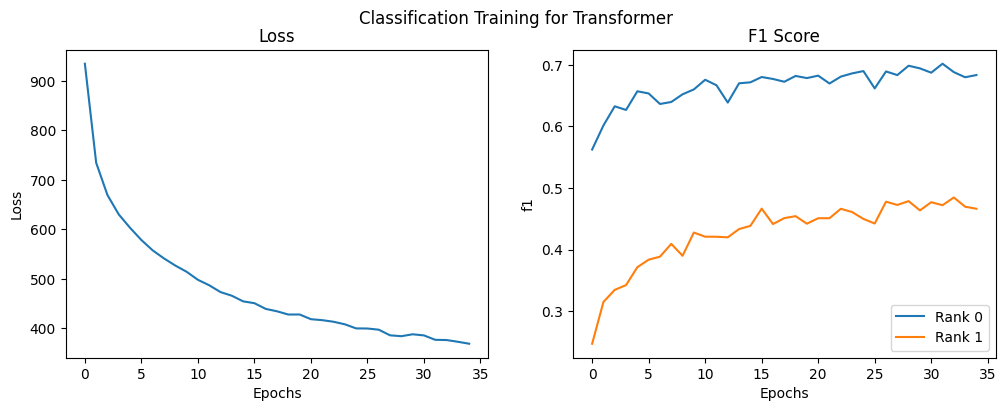

d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Test results: [0.70614, 0.50038]


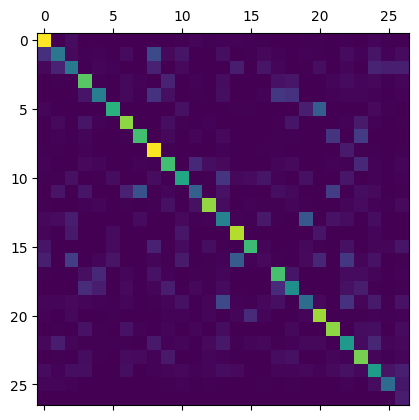

[[3426.   11.  115.    1.    0.    2.    3.    1.    2.    6.   18.   63.   22.   30.   33.   14.   14.    0.    0.   14.   20.    0.   14.    0.   63.   25.   21.]
 [ 466. 1358.   82.   14.   38.    6.   95.    3.  770.   84.  195.    4.    6.  126.    8.   20.   68.   31.   11.   35.   24.    9.   96.   31.  189.   35.  105.]
 [  76.  341. 1388.    0.   50.   29.    0.    0.  316.    4.   83.    5.    2.    6.  257.    1.  192.   50.    0.   26.  133.    0.   56.    2.  326.  283.  283.]
 [   2.   15.    0. 2547.   24.    0.   69.   28.   13.  344.    3.   27.    7.  108.    0.    0.    1.  164.  213.    3.    0.   54.   98.   49.   67.   16.   57.]
 [   8.    8.    2.  200. 1468.    1.   72.   21.  500.  143.    7.   25.   12.  129.    0.    9.   33.  561.  490.    6.    7.   28.   62.   41.   40.    4.   32.]
 [  49.    0.   13.    0.   13. 2192.    9.    0.    8.    4.  148.    1.    2.    1.   25.   16.    8.    0.    0.  284. 1025.    0.    6.    1.   82.   17.    5.]
 [   3.   

In [3]:
from torch import arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)


class T_2_tokens(Module):
    def __init__(self, N, M):
        super(T_2_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    transformer.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens, use_tokens=True),
    "Transformer",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

In [5]:
result = evaluate(model, test_data, "cuda", mapping, permute=False)
rounded_result = [float(f"{r:.5}") for r in result]
print(rounded_result)

[0.69781, 0.52673]


d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


### 4.2. Hybrid Model

Number of parameters: 1_093_186


  1%|          | 390/68609 [01:02<2:39:19,  7.14it/s]

N Reads: 50_048 Loss: 309.88. F1: [0.58596, 0.25064]. Patience: 20


  1%|          | 392/68609 [01:34<127:36:24,  6.73s/it]

F1 scores: [0.2872428  0.15725806 0.39473203 0.2571912  0.25003605 0.32833918
 0.63022508 0.49700957 0.39297012 0.06349206 0.15756245 0.37648131
 0.37620793 0.02923709 0.50049771 0.15246896 0.21232633 0.14721724
 0.07608696 0.17538577 0.41818992 0.50197771 0.12657343 0.12012987
 0.09536424 0.4815714  0.14367816]
Setting distributions: [0.03671462 0.03950097 0.03441049 0.03735881 0.03751218 0.03583368
 0.02936246 0.03221807 0.03444825 0.04151094 0.03949445 0.03480171
 0.03480757 0.04224523 0.03214329 0.03960363 0.03832053 0.03971621
 0.04124095 0.03911239 0.03390764 0.03211157 0.04015873 0.04029685
 0.04082773 0.032549   0.03979207]


  1%|          | 781/68609 [02:29<2:41:35,  7.00it/s]  

N Reads: 100_096 Loss: 242.78. F1: [0.59767, 0.31502]. Patience: 20


  1%|          | 783/68609 [03:02<129:25:14,  6.87s/it]

F1 scores: [0.46303292 0.16246259 0.43957346 0.31008122 0.37174721 0.41120264
 0.66912151 0.55728814 0.48396659 0.11358735 0.28706811 0.39352864
 0.52104915 0.10681696 0.51993166 0.27998931 0.15301807 0.20493443
 0.17445328 0.42184557 0.488023   0.51446775 0.12348112 0.22783052
 0.13211382 0.45628743 0.25506073]
Setting distributions: [0.03433947 0.04105492 0.03486361 0.03775677 0.036379   0.03549748
 0.02973496 0.03223358 0.03387176 0.0421469  0.03827093 0.03589236
 0.03304325 0.04229817 0.03306821 0.03842909 0.04126593 0.04010599
 0.04078702 0.03525969 0.03378113 0.03319029 0.04192585 0.03959444
 0.04173298 0.03449018 0.03898605]


  2%|▏         | 1172/68609 [03:59<10:46:44,  1.74it/s]

N Reads: 150_144 Loss: 224.57. F1: [0.62594, 0.35046]. Patience: 20


  2%|▏         | 1174/68609 [04:30<126:36:20,  6.76s/it]

F1 scores: [0.44727694 0.23477915 0.42727273 0.30270014 0.42887139 0.49410194
 0.73481247 0.51618652 0.45720324 0.25238206 0.29039301 0.5205111
 0.56242119 0.21665119 0.57445652 0.36965451 0.17445668 0.26111686
 0.17333701 0.4519962  0.45936163 0.52365797 0.12744479 0.27033871
 0.23090586 0.51188886 0.234375  ]
Setting distributions: [0.03548964 0.04034657 0.03594686 0.03879414 0.03591032 0.03441939
 0.02891762 0.03391462 0.03526276 0.03994423 0.03907544 0.03381577
 0.03285786 0.04076091 0.03258277 0.03726381 0.04172532 0.03974459
 0.04175092 0.03538177 0.03521343 0.03374385 0.04279985 0.03953381
 0.0404351  0.03401284 0.04035581]


  2%|▏         | 1563/68609 [05:27<12:09:40,  1.53it/s] 

N Reads: 200_192 Loss: 214.38. F1: [0.64654, 0.35168]. Patience: 20


  2%|▏         | 1565/68609 [05:58<127:01:29,  6.82s/it]

F1 scores: [0.58621614 0.21274962 0.44474613 0.37430572 0.42784871 0.3605176
 0.68457333 0.39505188 0.47983127 0.2593691  0.12512751 0.53713497
 0.59217877 0.14626012 0.53564936 0.35840089 0.29745042 0.25498008
 0.16292717 0.35197204 0.49516093 0.49522569 0.23727559 0.36604651
 0.3434824  0.5342917  0.1703638 ]
Setting distributions: [0.03229966 0.04083197 0.03553172 0.03714102 0.03591776 0.03745602
 0.03005256 0.03666704 0.03473015 0.03976689 0.0428338  0.03342098
 0.03216343 0.042351   0.03345492 0.03750438 0.03889687 0.03986716
 0.04197022 0.03765126 0.03437993 0.03437845 0.04027164 0.03732971
 0.03784521 0.03348594 0.04180032]


  3%|▎         | 1954/68609 [06:56<11:30:04,  1.61it/s] 

N Reads: 250_240 Loss: 206.69. F1: [0.65169, 0.36527]. Patience: 20


  3%|▎         | 1956/68609 [07:27<126:21:37,  6.82s/it]

F1 scores: [0.55753209 0.19634509 0.45757385 0.33806901 0.43351648 0.22610817
 0.71228473 0.6236952  0.44032698 0.38618246 0.11356209 0.60673121
 0.6553645  0.16052061 0.47243867 0.39141712 0.42547351 0.24212545
 0.19041409 0.40060883 0.5234938  0.44152342 0.25981222 0.33561818
 0.34847775 0.49340463 0.16525935]
Setting distributions: [0.03323496 0.04155684 0.03553804 0.03829147 0.03609233 0.04087109
 0.02966941 0.03171054 0.03593541 0.03718292 0.04346419 0.0321014
 0.03098087 0.04238225 0.03519555 0.03706231 0.03627764 0.04050204
 0.04169349 0.03685053 0.03401922 0.03590784 0.04009453 0.03834794
 0.03805165 0.03471248 0.04227306]


  3%|▎         | 2345/68609 [08:25<8:34:40,  2.15it/s]  

N Reads: 300_288 Loss: 199.81. F1: [0.65136, 0.38425]. Patience: 20


  3%|▎         | 2347/68609 [08:56<125:19:23,  6.81s/it]

F1 scores: [0.56800871 0.24499055 0.4747229  0.36528242 0.44543344 0.48430493
 0.74528782 0.61138686 0.48361333 0.38221048 0.30900517 0.63281641
 0.66424242 0.15513514 0.57334226 0.26079347 0.19837272 0.25876663
 0.23342175 0.41185984 0.49943246 0.54430727 0.22658341 0.35072032
 0.31114193 0.49426934 0.20485175]
Setting distributions: [0.03340646 0.04094205 0.0355827  0.0381358  0.03626598 0.03535916
 0.02927078 0.03239451 0.0353753  0.03774089 0.03944867 0.03189458
 0.03116146 0.04303826 0.03328204 0.04057339 0.04202958 0.04062067
 0.04121193 0.03704921 0.03500626 0.03395939 0.04137146 0.03847551
 0.03939883 0.0351267  0.04187843]


  4%|▍         | 2736/68609 [09:55<8:01:03,  2.28it/s]  

N Reads: 350_336 Loss: 194.48. F1: [0.66995, 0.41674]. Patience: 20


  4%|▍         | 2738/68609 [10:26<124:53:56,  6.83s/it]

F1 scores: [0.56457266 0.24213406 0.53330057 0.4005848  0.44194313 0.55654042
 0.65698368 0.60709677 0.53643999 0.43116754 0.27250069 0.61494662
 0.67345158 0.2999272  0.54800227 0.46512861 0.44578976 0.29019981
 0.17082141 0.47144152 0.58328926 0.47302421 0.26013868 0.34329114
 0.36977676 0.58233438 0.23164763]
Setting distributions: [0.03423102 0.0419203  0.03497677 0.03814168 0.0371554  0.03442257
 0.03202727 0.03321694 0.03490191 0.03741237 0.04119614 0.03302974
 0.03163456 0.04054209 0.03462618 0.03660249 0.03706367 0.04077406
 0.04362091 0.03645194 0.03378468 0.0364142  0.04149094 0.03950798
 0.03887637 0.03380745 0.04217037]


  5%|▍         | 3127/68609 [11:24<7:40:08,  2.37it/s]  

N Reads: 400_384 Loss: 189.35. F1: [0.63445, 0.38953]. Patience: 19


  5%|▍         | 3129/68609 [11:55<124:04:24,  6.82s/it]

F1 scores: [0.57122058 0.19792961 0.43787734 0.4415078  0.47597931 0.49982859
 0.70133275 0.60462211 0.54723926 0.33883884 0.21931956 0.60302775
 0.65098566 0.17266897 0.62472674 0.21462748 0.32460733 0.27824192
 0.29168646 0.36863303 0.58725926 0.50703491 0.23404608 0.31339894
 0.31100757 0.56588629 0.17614679]
Setting distributions: [0.03342931 0.04216324 0.03654916 0.03646422 0.03565768 0.03509968
 0.03038506 0.03264781 0.0339904  0.03886637 0.04166278 0.03268512
 0.03156304 0.04275427 0.03217742 0.04177256 0.03919935 0.04028417
 0.0399696  0.03816927 0.03305405 0.03493107 0.04131822 0.03946159
 0.03951754 0.03355412 0.0426729 ]


  5%|▌         | 3518/68609 [12:54<6:45:07,  2.68it/s]  

N Reads: 450_432 Loss: 185.92. F1: [0.66519, 0.41362]. Patience: 18


  5%|▌         | 3520/68609 [13:26<123:47:22,  6.85s/it]

F1 scores: [0.62007478 0.20289855 0.54349904 0.32915567 0.44666191 0.54751526
 0.71927943 0.59427012 0.49699289 0.42467324 0.39137974 0.54046714
 0.69136433 0.18553689 0.60958437 0.35545557 0.23390895 0.32895888
 0.36548488 0.47782483 0.59365624 0.52200978 0.21539436 0.32625698
 0.35394769 0.62404871 0.19096774]
Setting distributions: [0.03280168 0.04271822 0.03462194 0.03971701 0.03692382 0.03452647
 0.03044353 0.03341508 0.03572742 0.0374465  0.03823791 0.03469401
 0.03110709 0.04313092 0.03305105 0.03909185 0.04198109 0.03972169
 0.03885344 0.03618305 0.03342967 0.03513275 0.04242119 0.03978592
 0.03912769 0.03270722 0.04300183]


  6%|▌         | 3909/68609 [14:24<6:05:07,  2.95it/s]  

N Reads: 500_480 Loss: 182.95. F1: [0.66096, 0.4209]. Patience: 18


  6%|▌         | 3911/68609 [14:56<122:19:26,  6.81s/it]

F1 scores: [0.56359482 0.20465827 0.5330853  0.45980032 0.4625091  0.53772944
 0.68365628 0.625367   0.53878282 0.46316391 0.41712707 0.61000685
 0.69167473 0.19308209 0.65648148 0.38256549 0.29469315 0.31802366
 0.32820258 0.49526694 0.48180924 0.52303523 0.2417428  0.33236918
 0.31847134 0.63157895 0.16224986]
Setting distributions: [0.0343233  0.04290019 0.03505233 0.0368035  0.03673877 0.03494136
 0.0314544  0.03284724 0.03491619 0.03672313 0.03782319 0.03321427
 0.0312628  0.04317681 0.03210375 0.03864905 0.04074878 0.04019129
 0.03994806 0.03595602 0.03627759 0.03529248 0.04201405 0.0398485
 0.0401806  0.0326988  0.04391355]


  6%|▋         | 4300/68609 [15:55<5:18:34,  3.36it/s]  

N Reads: 550_528 Loss: 180.72. F1: [0.65555, 0.41993]. Patience: 17


  6%|▋         | 4302/68609 [16:26<120:15:34,  6.73s/it]

F1 scores: [0.55114007 0.1929888  0.48626374 0.49436586 0.45395068 0.49081803
 0.63446721 0.59628841 0.56463023 0.41225461 0.36775451 0.62397756
 0.69010863 0.16902357 0.63487064 0.42586086 0.28797565 0.35032993
 0.30297619 0.49363124 0.55464481 0.5        0.24043716 0.36739974
 0.39340508 0.63049933 0.21917808]
Setting distributions: [0.03460314 0.04315688 0.03615259 0.03595908 0.03692432 0.03604382
 0.03261304 0.03352487 0.03428096 0.03792015 0.03898294 0.03286357
 0.03128416 0.04372924 0.03260341 0.03759519 0.0408883  0.0393991
 0.04053005 0.03597663 0.03451944 0.03582452 0.04202367 0.03899142
 0.03837033 0.03270781 0.0425314 ]


  7%|▋         | 4691/68609 [17:25<5:18:23,  3.35it/s]  

N Reads: 600_576 Loss: 176.86. F1: [0.67681, 0.43491]. Patience: 17


  7%|▋         | 4693/68609 [17:57<120:42:14,  6.80s/it]

F1 scores: [0.62060835 0.22682119 0.53559666 0.4032392  0.42241888 0.49873509
 0.78758586 0.64040284 0.52528013 0.38226559 0.42686101 0.63200982
 0.68667917 0.21129771 0.66944376 0.35893789 0.32312566 0.36492221
 0.3221865  0.48584633 0.64953271 0.49570025 0.27056164 0.37816245
 0.38712687 0.64521948 0.20779221]
Setting distributions: [0.03328516 0.04278737 0.03533652 0.03853035 0.03806754 0.036226
 0.02925594 0.03280751 0.03558546 0.03903645 0.03796035 0.03301004
 0.03169085 0.04316196 0.03210675 0.03959935 0.04046351 0.03945495
 0.04048617 0.03653701 0.03258721 0.03629923 0.0417319  0.03913546
 0.03891914 0.03269129 0.04324655]


  7%|▋         | 5082/68609 [18:56<5:27:18,  3.23it/s]  

N Reads: 650_624 Loss: 174.83. F1: [0.67595, 0.42967]. Patience: 16


  7%|▋         | 5084/68609 [19:27<119:51:33,  6.79s/it]

F1 scores: [0.5462963  0.22015241 0.55007549 0.39532834 0.4589205  0.62980769
 0.80107396 0.62021343 0.45769591 0.39112612 0.40597317 0.65431497
 0.65701649 0.21543496 0.71084663 0.39582881 0.18906942 0.30141605
 0.37758112 0.48596851 0.5210833  0.54764107 0.22613065 0.37631328
 0.36835675 0.67292729 0.21202003]
Setting distributions: [0.03493524 0.04277309 0.03484442 0.03856328 0.03703504 0.0329283
 0.02881245 0.03315887 0.03706447 0.03866427 0.03830747 0.03233935
 0.03227442 0.04288646 0.03098078 0.03855125 0.04352007 0.04082017
 0.03898978 0.03638503 0.03554115 0.03490292 0.04262942 0.03902025
 0.03921146 0.03189206 0.04296853]


  8%|▊         | 5473/68609 [20:26<4:38:41,  3.78it/s]  

N Reads: 700_672 Loss: 171.99. F1: [0.69283, 0.43998]. Patience: 16


  8%|▊         | 5475/68609 [20:58<119:30:36,  6.81s/it]

F1 scores: [0.59102417 0.22753504 0.53076041 0.42607611 0.46153846 0.47889322
 0.78329356 0.5735775  0.47105509 0.4185479  0.38786765 0.61365678
 0.72399445 0.2141527  0.65994236 0.35876623 0.36766121 0.3255814
 0.39300135 0.53735314 0.60294118 0.54568474 0.24073266 0.39843176
 0.42330338 0.69055007 0.29562982]
Setting distributions: [0.03415    0.04296005 0.03561064 0.03814792 0.0372884  0.03686777
 0.02948987 0.03457286 0.03705774 0.03833038 0.03907399 0.03360144
 0.03092713 0.0432844  0.03247959 0.03977934 0.03956375 0.04058365
 0.03894957 0.03545085 0.03386116 0.03524891 0.04264017 0.03881795
 0.03821512 0.03173774 0.04130961]


  9%|▊         | 5864/68609 [21:57<4:33:24,  3.82it/s]  

N Reads: 750_720 Loss: 171.25. F1: [0.65887, 0.43265]. Patience: 15


  9%|▊         | 5866/68609 [22:29<118:17:50,  6.79s/it]

F1 scores: [0.54701299 0.23676471 0.44406548 0.48350838 0.45120724 0.63332347
 0.75415104 0.60596925 0.49569927 0.49014085 0.40276976 0.55461659
 0.69255814 0.2234375  0.69950272 0.3655914  0.31143114 0.28765852
 0.36165834 0.46104694 0.5561753  0.51712993 0.29888451 0.34419971
 0.43480533 0.63850045 0.16810345]
Setting distributions: [0.03497795 0.0424466  0.03745622 0.0365067  0.03728429 0.03290018
 0.02999149 0.03355869 0.03621323 0.03634704 0.03845033 0.03479491
 0.03147422 0.04276742 0.03130704 0.03934533 0.04064914 0.04122142
 0.03944001 0.03704742 0.03475738 0.03569733 0.04095118 0.0398603
 0.03767914 0.03277556 0.04409949]


  9%|▉         | 6255/68609 [23:28<4:33:06,  3.81it/s]  

N Reads: 800_768 Loss: 167.82. F1: [0.66182, 0.44161]. Patience: 15


  9%|▉         | 6257/68609 [24:00<117:18:20,  6.77s/it]

F1 scores: [0.54400355 0.23502654 0.47674419 0.51817335 0.47075055 0.64492177
 0.77069597 0.61942257 0.51358696 0.43633228 0.40649464 0.63127001
 0.68763006 0.20949584 0.68922377 0.43079743 0.30237028 0.34911792
 0.39139344 0.46504814 0.56982422 0.55288707 0.26882217 0.3383908
 0.40119924 0.62766277 0.16692913]
Setting distributions: [0.03526971 0.04275429 0.03689898 0.03589541 0.03704417 0.03282509
 0.02977836 0.03344277 0.03600651 0.03787791 0.03860069 0.03315578
 0.03179053 0.04337274 0.03175193 0.03801198 0.04112297 0.03999057
 0.0389665  0.0371823  0.03464423 0.03505451 0.04193563 0.04025042
 0.03872896 0.03324317 0.04440387]


 10%|▉         | 6646/68609 [24:59<3:48:29,  4.52it/s]  

N Reads: 850_816 Loss: 166.44. F1: [0.68169, 0.45278]. Patience: 15


 10%|▉         | 6648/68609 [25:31<117:58:32,  6.85s/it]

F1 scores: [0.59472422 0.22939959 0.5406234  0.44097721 0.44905009 0.6695627
 0.76596819 0.6010101  0.52787896 0.48027112 0.49840256 0.63129452
 0.69719492 0.20875421 0.6880628  0.35740583 0.37763417 0.31941683
 0.32297012 0.52305003 0.64674672 0.56632403 0.25084582 0.36481094
 0.42323409 0.64560099 0.29132948]
Setting distributions: [0.03436936 0.04330424 0.03569253 0.03812961 0.03793217 0.03253901
 0.03018118 0.03421563 0.03600422 0.03716858 0.03672514 0.03347495
 0.0318632  0.04380918 0.03208654 0.04017355 0.03967882 0.04110266
 0.04101575 0.03612232 0.03309703 0.03506396 0.04277973 0.03999244
 0.03856356 0.03312505 0.0417896 ]


 10%|█         | 7037/68609 [26:31<3:56:31,  4.34it/s]  

N Reads: 900_864 Loss: 165.60. F1: [0.69286, 0.45727]. Patience: 15


 10%|█         | 7039/68609 [27:03<115:39:12,  6.76s/it]

F1 scores: [0.60202755 0.28718325 0.54060491 0.48191639 0.50754936 0.58454647
 0.75526958 0.62930078 0.54063709 0.49339672 0.42425906 0.6213705
 0.72198172 0.18545994 0.70291955 0.45794126 0.38264175 0.32097187
 0.4250695  0.4730444  0.57512838 0.49717514 0.24268939 0.39377289
 0.44843276 0.64160839 0.23566379]
Setting distributions: [0.034241   0.04195259 0.03574545 0.03718293 0.03655509 0.03466917
 0.0304876  0.03357299 0.03574466 0.03690173 0.03859515 0.03376723
 0.03130293 0.04444413 0.03176982 0.03777016 0.03961449 0.04112499
 0.0385753  0.03740023 0.03489985 0.03680919 0.04304239 0.03934185
 0.03800305 0.03327154 0.04321447]


 11%|█         | 7428/68609 [28:02<3:25:21,  4.97it/s]  

N Reads: 950_912 Loss: 164.23. F1: [0.65964, 0.46468]. Patience: 15


 11%|█         | 7430/68609 [28:34<115:29:47,  6.80s/it]

F1 scores: [0.57920411 0.20108469 0.52622995 0.47670427 0.46919113 0.65409991
 0.76996047 0.65221113 0.54926511 0.50150263 0.46905906 0.65520535
 0.71005917 0.22637979 0.71802853 0.38779825 0.39839901 0.43003953
 0.35691318 0.52896613 0.68990447 0.57387365 0.22300677 0.3507371
 0.34643875 0.6553773  0.28070175]
Setting distributions: [0.03497804 0.04428681 0.03628219 0.03750144 0.0376864  0.0331342
 0.03028188 0.0331807  0.03571509 0.03689094 0.03768966 0.03310699
 0.03175656 0.04366408 0.03156037 0.03969018 0.03942921 0.03865026
 0.04045053 0.03621483 0.03225275 0.03510926 0.04374712 0.04060258
 0.0407084  0.03310276 0.04232675]


 11%|█▏        | 7819/68609 [29:34<3:18:32,  5.10it/s]  

N Reads: 1_000_960 Loss: 163.35. F1: [0.68325, 0.4583]. Patience: 14


 11%|█▏        | 7821/68609 [30:05<113:08:54,  6.70s/it]

F1 scores: [0.59337143 0.23476848 0.54826884 0.45852653 0.44939271 0.62461279
 0.77860697 0.60915308 0.54714544 0.49779736 0.39650941 0.65559932
 0.66098272 0.18346167 0.65695981 0.40932061 0.39785587 0.36767461
 0.36704545 0.54541176 0.67966574 0.53075292 0.25753831 0.39268051
 0.41377525 0.71223994 0.2345679 ]
Setting distributions: [0.0344793  0.04326939 0.03558486 0.03778463 0.03800851 0.03371352
 0.02993881 0.03409246 0.0356124  0.03682202 0.03930479 0.03295397
 0.03282202 0.04452702 0.03292063 0.03899076 0.03927179 0.04001159
 0.04002701 0.03565489 0.03236406 0.03601421 0.04271125 0.03939864
 0.03888157 0.0315656  0.0432743 ]


 12%|█▏        | 8210/68609 [31:04<3:17:46,  5.09it/s]  

N Reads: 1_051_008 Loss: 161.63. F1: [0.67339, 0.46028]. Patience: 13


 12%|█▏        | 8212/68609 [31:36<113:55:05,  6.79s/it]

F1 scores: [0.60628743 0.27734651 0.49326068 0.51166448 0.54010821 0.61591104
 0.75175013 0.59491979 0.54646465 0.46611469 0.45566309 0.66632151
 0.68817818 0.27898942 0.66897188 0.32645403 0.47283951 0.34657763
 0.34291744 0.49277061 0.64572606 0.54387171 0.2751896  0.40316775
 0.45783133 0.6017192  0.1541502 ]
Setting distributions: [0.03418071 0.04224796 0.03695268 0.03650133 0.03580375 0.03394469
 0.03061324 0.0344595  0.03564786 0.03761843 0.03787476 0.03270837
 0.03217234 0.04220767 0.03264337 0.0410436  0.03745351 0.04055007
 0.04063984 0.0369647  0.03321348 0.03571145 0.04230086 0.0391622
 0.03782158 0.03429274 0.04526934]


 13%|█▎        | 8601/68609 [32:35<2:57:53,  5.62it/s]  

N Reads: 1_101_056 Loss: 160.98. F1: [0.67709, 0.44498]. Patience: 12


 13%|█▎        | 8603/68609 [33:06<112:14:24,  6.73s/it]

F1 scores: [0.58919722 0.22974102 0.57171364 0.4922789  0.48996991 0.5841785
 0.7016441  0.61007958 0.5576002  0.51429889 0.44438503 0.50781499
 0.71092077 0.19242902 0.66456362 0.39020363 0.41800835 0.35712546
 0.3424306  0.53094216 0.5450031  0.48746602 0.32944958 0.36895885
 0.35969084 0.64180025 0.18081181]
Setting distributions: [0.03425335 0.04298071 0.03467784 0.03660646 0.03666252 0.0343752
 0.03152321 0.03374634 0.0350205  0.03607183 0.03776929 0.03622926
 0.03129798 0.04388662 0.0324235  0.03908478 0.0384097  0.0398879
 0.04024468 0.03566774 0.03532635 0.03672332 0.04055985 0.03960059
 0.03982561 0.03297618 0.04416867]


 13%|█▎        | 8992/68609 [34:05<3:00:16,  5.51it/s]  

N Reads: 1_151_104 Loss: 159.16. F1: [0.6914, 0.47737]. Patience: 12


 13%|█▎        | 8994/68609 [34:37<111:59:09,  6.76s/it]

F1 scores: [0.65525807 0.2213868  0.5076574  0.50269107 0.53541768 0.6324837
 0.7980038  0.62062833 0.55139289 0.48907513 0.51004016 0.66722902
 0.7250996  0.29813665 0.68666379 0.41871078 0.39925174 0.33743085
 0.37582825 0.56373104 0.61179698 0.57746145 0.27877386 0.37279903
 0.47284879 0.66110951 0.25128205]
Setting distributions: [0.03338667 0.04415864 0.03705123 0.03717454 0.03636201 0.0339521
 0.02984264 0.03424644 0.03596539 0.03751259 0.03699208 0.03308946
 0.03165267 0.04225312 0.03260694 0.03925956 0.03974268 0.04127754
 0.04032423 0.03565906 0.0344657  0.03531817 0.04273385 0.04039944
 0.03791545 0.03324139 0.04341641]


 14%|█▎        | 9383/68609 [35:36<3:03:59,  5.36it/s]  

N Reads: 1_201_152 Loss: 157.73. F1: [0.67774, 0.44815]. Patience: 11


 14%|█▎        | 9385/68609 [36:08<109:56:21,  6.68s/it]

F1 scores: [0.61499579 0.22033898 0.50478838 0.4858867  0.49280576 0.58831044
 0.75926795 0.65410498 0.60657534 0.5537672  0.37238938 0.65844774
 0.66311694 0.19894282 0.66127024 0.46912574 0.29951691 0.28789455
 0.33127699 0.46008584 0.59460888 0.51788645 0.27870731 0.34509804
 0.43298969 0.65714286 0.17586207]
Setting distributions: [0.03368627 0.04328517 0.03636675 0.03682648 0.0366582  0.03433532
 0.03017726 0.03273505 0.03389108 0.03517548 0.03958698 0.03262943
 0.03251586 0.04380557 0.03256078 0.03723414 0.0413594  0.04164208
 0.04058692 0.03745401 0.03418213 0.03604818 0.04186553 0.04025076
 0.03811305 0.03266117 0.04436695]


 14%|█▍        | 9774/68609 [37:08<2:51:42,  5.71it/s]  

N Reads: 1_251_200 Loss: 157.34. F1: [0.70008, 0.46238]. Patience: 10


 14%|█▍        | 9776/68609 [37:40<112:04:19,  6.86s/it]

F1 scores: [0.62493664 0.26933436 0.53701175 0.46631867 0.51969309 0.63731544
 0.75580866 0.64080024 0.51098512 0.5047089  0.42319227 0.6446633
 0.71287583 0.26052458 0.68295218 0.44719472 0.27546917 0.35636856
 0.36556064 0.4484289  0.59512195 0.55494649 0.26849315 0.38421053
 0.4960779  0.69670443 0.2679803 ]
Setting distributions: [0.03382496 0.04257237 0.03598782 0.03772678 0.03641383 0.03352046
 0.03060566 0.03343474 0.03662804 0.03678243 0.03878764 0.03333971
 0.03166176 0.04278908 0.03239785 0.03819721 0.04242146 0.04043143
 0.04020531 0.03816685 0.03455837 0.03554664 0.04259306 0.03974655
 0.03699474 0.03205956 0.04260568]


 15%|█▍        | 10165/68609 [38:40<2:47:56,  5.80it/s] 

N Reads: 1_301_248 Loss: 156.61. F1: [0.68033, 0.4534]. Patience: 9


 15%|█▍        | 10167/68609 [39:12<111:05:28,  6.84s/it]

F1 scores: [0.55286252 0.31341108 0.50268577 0.51635351 0.51978239 0.45397048
 0.79843635 0.65163205 0.54792561 0.53950557 0.36708034 0.59910486
 0.6866417  0.25767148 0.65496837 0.43263218 0.34639697 0.44746601
 0.41418884 0.42030697 0.56964184 0.4732475  0.30149481 0.38335373
 0.45656961 0.66038292 0.18870267]
Setting distributions: [0.03534467 0.041193   0.03657018 0.03623636 0.03615261 0.03775999
 0.02934681 0.03293234 0.03546525 0.0356709  0.03988219 0.03421525
 0.03207727 0.04255437 0.03285085 0.03828116 0.04038735 0.03791886
 0.03873162 0.03858219 0.03493485 0.03728918 0.04148404 0.03948473
 0.03769651 0.03271861 0.04423886]


 15%|█▌        | 10556/68609 [40:11<2:38:47,  6.09it/s]  

N Reads: 1_351_296 Loss: 156.23. F1: [0.69232, 0.46151]. Patience: 8


 15%|█▌        | 10558/68609 [40:44<110:54:21,  6.88s/it]

F1 scores: [0.61172431 0.27482014 0.51699974 0.49172386 0.51925134 0.60364535
 0.71434726 0.62727936 0.51399941 0.5259481  0.35045108 0.61065089
 0.68213018 0.27755511 0.70596145 0.37231504 0.39646321 0.40945347
 0.38591848 0.52       0.57128489 0.55753564 0.31583282 0.35589713
 0.42382873 0.6824423  0.3465704 ]
Setting distributions: [0.03416371 0.0424545  0.03649477 0.03711677 0.03643936 0.03436253
 0.03163829 0.03378092 0.0365686  0.03627456 0.04059332 0.03419013
 0.03243111 0.0423872  0.03184466 0.04005527 0.03946102 0.03914134
 0.03972051 0.03642093 0.03515888 0.03549723 0.04144523 0.0404593
 0.03878759 0.03242343 0.04068882]


 16%|█▌        | 10947/68609 [41:43<2:36:20,  6.15it/s]  

N Reads: 1_401_344 Loss: 154.43. F1: [0.70137, 0.47398]. Patience: 7


 16%|█▌        | 10949/68609 [42:15<107:38:52,  6.72s/it]

F1 scores: [0.6070529  0.25423091 0.55493896 0.48095238 0.48801534 0.53499696
 0.80975119 0.63617945 0.54144806 0.44256065 0.46261161 0.66576087
 0.69509103 0.26396256 0.71422018 0.5055904  0.44258373 0.38784293
 0.37856273 0.53874004 0.60607394 0.59357278 0.32936786 0.3181948
 0.40715884 0.70147622 0.24978317]
Setting distributions: [0.03448804 0.04322358 0.03577833 0.03761017 0.0374353  0.03627208
 0.02946942 0.03376689 0.03611235 0.03856071 0.03806427 0.03303449
 0.0323083  0.04298263 0.03183468 0.03700015 0.03856014 0.03991547
 0.04014524 0.0361794  0.03451228 0.0348218  0.04136326 0.04163989
 0.03943723 0.03215021 0.0433337 ]


 17%|█▋        | 11338/68609 [43:15<2:36:03,  6.12it/s]  

N Reads: 1_451_392 Loss: 153.53. F1: [0.6795, 0.43757]. Patience: 6


 17%|█▋        | 11340/68609 [43:47<108:51:21,  6.84s/it]

F1 scores: [0.58133605 0.25099746 0.50867052 0.49545789 0.46061241 0.51644853
 0.74307497 0.62908195 0.50173947 0.44359318 0.32175122 0.71171382
 0.68727758 0.24739692 0.69794202 0.44352546 0.21496985 0.34018568
 0.35347261 0.41635378 0.58667335 0.59378396 0.27865291 0.29667149
 0.41848464 0.66528436 0.32196453]
Setting distributions: [0.03437278 0.04237655 0.0361334  0.03645353 0.0372978  0.03594494
 0.03045402 0.03321595 0.03630133 0.03771015 0.04066226 0.03121386
 0.03180593 0.04246379 0.03154754 0.0377118  0.04324947 0.04021561
 0.03989368 0.03837014 0.03424347 0.03407118 0.04170649 0.04126992
 0.03831851 0.0323388  0.04065709]


 17%|█▋        | 11729/68609 [44:47<2:32:04,  6.23it/s]  

N Reads: 1_501_440 Loss: 153.86. F1: [0.68972, 0.46397]. Patience: 5


 17%|█▋        | 11731/68609 [45:19<109:22:19,  6.92s/it]

F1 scores: [0.55963512 0.29654404 0.45082508 0.46478261 0.52106252 0.59783263
 0.78309078 0.60835763 0.53463534 0.51657672 0.47864128 0.69968285
 0.71754636 0.31313673 0.6614594  0.40784747 0.43019528 0.34806132
 0.40965274 0.50481768 0.56924059 0.54964452 0.28830084 0.33962264
 0.48092002 0.62901235 0.19678218]
Setting distributions: [0.03544022 0.04191359 0.0381175  0.03777407 0.0363893  0.03450037
 0.02994209 0.0342414  0.03605534 0.03649968 0.03743308 0.03199434
 0.03155481 0.04150532 0.03293483 0.03917496 0.0386251  0.040646
 0.03913055 0.03678901 0.03520388 0.03568604 0.04211641 0.04085364
 0.03737701 0.03373319 0.04436823]


 18%|█▊        | 12120/68609 [46:19<2:27:04,  6.40it/s]  

N Reads: 1_551_488 Loss: 152.67. F1: [0.69116, 0.45042]. Patience: 4


 18%|█▊        | 12122/68609 [46:50<104:58:40,  6.69s/it]

F1 scores: [0.6058072  0.27419355 0.49275362 0.47890871 0.47250194 0.51464129
 0.78404669 0.65102639 0.4820827  0.4240251  0.487214   0.68808239
 0.70365102 0.22183965 0.63829016 0.40593244 0.32047293 0.3706721
 0.32698908 0.52457444 0.58667997 0.48627914 0.33063988 0.33670374
 0.4565378  0.70011338 0.25174825]
Setting distributions: [0.03401832 0.04210969 0.03677682 0.03711464 0.03727097 0.03624277
 0.02966927 0.03291497 0.03703719 0.0384538  0.03691199 0.0320108
 0.03163093 0.04338713 0.03322573 0.03889526 0.04098047 0.03975561
 0.04082148 0.0360004  0.03448502 0.0369348  0.0407324  0.04058444
 0.03766049 0.03171724 0.04265736]


 18%|█▊        | 12511/68609 [47:49<2:26:08,  6.40it/s]  

N Reads: 1_601_536 Loss: 151.54. F1: [0.70107, 0.46948]. Patience: 3


 18%|█▊        | 12513/68609 [48:21<103:38:56,  6.65s/it]

F1 scores: [0.65043567 0.25806452 0.54801251 0.41317179 0.50172918 0.54940838
 0.72396857 0.62841069 0.54117024 0.5198964  0.44217054 0.70599295
 0.70568876 0.26315789 0.69148207 0.50593437 0.46317712 0.39569452
 0.37953092 0.49010506 0.62481962 0.54000495 0.29718457 0.3087445
 0.4460987  0.70028818 0.22648402]
Setting distributions: [0.03333972 0.04303288 0.03586999 0.0392011  0.03701337 0.03583551
 0.03152316 0.03388383 0.03603902 0.03656457 0.03848472 0.03196723
 0.03197474 0.04290705 0.03232571 0.03690949 0.03796577 0.03963286
 0.04003217 0.03730054 0.03397254 0.03606781 0.04206646 0.04178088
 0.03838767 0.03210816 0.04381305]


 19%|█▉        | 12902/68609 [49:20<2:24:34,  6.42it/s]  

N Reads: 1_651_584 Loss: 151.36. F1: [0.70406, 0.46574]. Patience: 2


 19%|█▉        | 12904/68609 [49:52<104:08:46,  6.73s/it]

F1 scores: [0.62798315 0.28386606 0.54100202 0.50905578 0.49905072 0.52577672
 0.78161435 0.63736264 0.51034483 0.48306745 0.39510371 0.6550765
 0.74036767 0.2858429  0.71095238 0.43555094 0.40262843 0.42400244
 0.37111671 0.48086992 0.55313289 0.54084893 0.31417795 0.35449598
 0.44426274 0.67894896 0.2587156 ]
Setting distributions: [0.0338312  0.04231644 0.03597598 0.03676371 0.03701041 0.0363514
 0.03004296 0.03359992 0.03673192 0.03740453 0.03957354 0.03316313
 0.03106002 0.04226769 0.03178534 0.03857619 0.039388   0.03886096
 0.04016501 0.03745872 0.03567686 0.03597975 0.04156901 0.04057485
 0.03836138 0.03257448 0.0429366 ]


 19%|█▉        | 13293/68609 [50:51<2:21:35,  6.51it/s]  

N Reads: 1_701_632 Loss: 149.33. F1: [0.68442, 0.45667]. Patience: 1


 19%|█▉        | 13295/68609 [51:23<102:17:07,  6.66s/it]

F1 scores: [0.58735554 0.26640316 0.52835676 0.51215039 0.5451664  0.54871448
 0.77401692 0.6613143  0.53214958 0.42496454 0.45086393 0.68875193
 0.71904762 0.26938776 0.70276368 0.3832636  0.27998568 0.36899906
 0.38337723 0.46855563 0.5369629  0.54829898 0.28838343 0.32125418
 0.46635281 0.69664804 0.19602978]
Setting distributions: [0.03458085 0.04243761 0.03602511 0.03642184 0.03561362 0.03552677
 0.03001147 0.03277038 0.03593227 0.0385561  0.0379221  0.03209872
 0.03135709 0.04236455 0.03175572 0.03957692 0.04210512 0.03992611
 0.03957414 0.03748902 0.03581444 0.03553694 0.04189954 0.04109488
 0.03754294 0.03190542 0.04416032]


 20%|█▉        | 13684/68609 [52:22<2:17:35,  6.65it/s]  

N Reads: 1_751_680 Loss: 149.34. F1: [0.69017, 0.4784]. Patience: 1


 20%|█▉        | 13686/68609 [52:53<102:00:44,  6.69s/it]

F1 scores: [0.55943457 0.22083852 0.54498582 0.52469464 0.48045857 0.61424771
 0.81589744 0.64709336 0.49763183 0.48882931 0.48184615 0.74679049
 0.67972205 0.25593271 0.74885182 0.5202668  0.37610359 0.40418605
 0.38076037 0.49841203 0.60644451 0.57242583 0.28269618 0.36901847
 0.44498251 0.70389171 0.31617647]
Setting distributions: [0.03581947 0.04423862 0.03617874 0.03668328 0.0377832  0.03445655
 0.02944256 0.03363985 0.03735619 0.03757507 0.0377487  0.03116089
 0.03282854 0.04336601 0.03110964 0.03679338 0.04037798 0.03967971
 0.04026219 0.03733679 0.03465058 0.03549645 0.04270054 0.04055415
 0.03866531 0.03222757 0.04186806]


 21%|██        | 14075/68609 [54:09<3:29:49,  4.33it/s]  

N Reads: 1_801_728 Loss: 149.18. F1: [0.68992, 0.46418]. Patience: 0
The model is overfitting; stopping early.
Processed 1_801_728 reads.
Training took 3249.282 s.


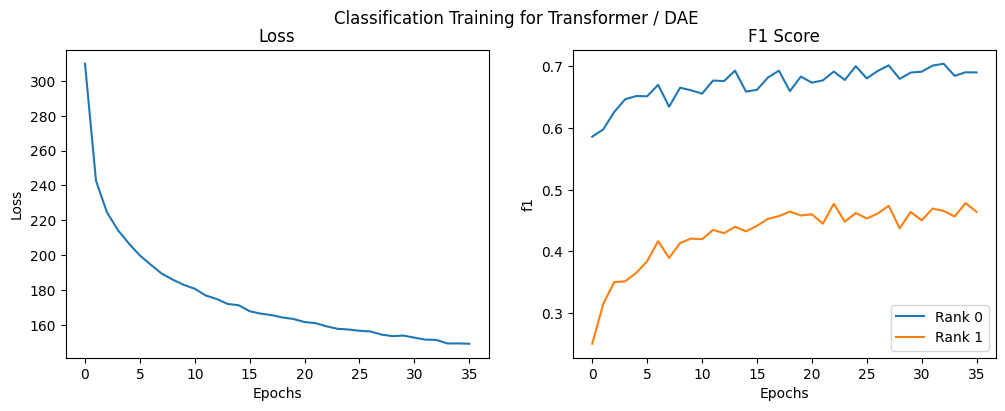

Test results: [0.71028, 0.47808]


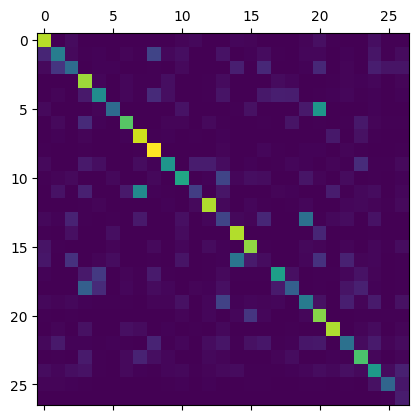

[[3145.    9.  108.    0.    0.    6.    1.    1.    0.    8.   51.   70.   12.   12.   60.   46.   11.    0.    0.   42.  144.   17.    7.    2.  130.   14.   22.]
 [ 366. 1495.   84.   15.   39.    7.   53.   20.  719.   76.  135.   12.   10.  173.   12.   31.  114.   25.    7.   68.   62.    8.   40.   12.  203.   26.   97.]
 [  92.  540. 1244.    0.   35.   30.    0.    0.   15.    7.   90.    6.    5.    5.  301.    4.  393.   12.    0.   35.  386.    0.   50.    4.  282.  190.  183.]
 [  12.   13.    1. 3009.   67.    0.   62.   27.   21.  134.    3.   10.   17.  108.    0.    0.    7.  105.   68.   10.   10.   14.   51.   39.   61.   11.   49.]
 [   6.   42.    7.  234. 1708.    0.   61.   25.  416.  137.   12.    9.   21.  183.    0.   11.  233.  293.  286.   12.   22.   36.   62.   24.   28.    6.   35.]
 [  88.    0.   10.    1.   42. 1234.    2.    0.    3.    2.  171.    3.    0.    0.   26.  163.    4.    0.    0.  238. 1869.    0.    9.    6.   33.    1.    4.]
 [   7.   

In [4]:
model = benchmark(
    hybrid.Classifier(LENGTH // 4, mapping, "cuda", hybrid.T_DAE_hybrid_1),
    "Transformer / DAE",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)
result = evaluate(model, test_data, "cuda", mapping, permute=False)
rounded_result = [float(f"{r:.5}") for r in result]
print(rounded_result)

## 5. BerTax Data

This section trains models with the same data used by the BerTax model.

### 5.0. Prepare Data

In [3]:
BERTAX_DIRECTORY = DATA_DIRECTORY + "bertax/non_similar/"
BERTAX_TRAIN = BERTAX_DIRECTORY + "train/"
BERTAX_TEST = BERTAX_DIRECTORY + "test/"
BERTAX_RAW_DATA = BERTAX_DIRECTORY + "non_similar_dataset/"

mkdir(BERTAX_TRAIN)
mkdir(BERTAX_TEST)

In [3]:
tax_ids = set()
for dataset in ("train.fa", "test.fa"):
    with open(BERTAX_RAW_DATA + dataset, "r") as f:
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                tax_ids.add(tax_id)

parents, ranks = ncbi.get_all_taxonomy_parents(
    NCBI_TAXONOMY_DIRECTORY + "nodes.dmp",
    NCBI_TAXONOMY_DIRECTORY + "merged.dmp",
)
names = ncbi.taxid_to_names(NCBI_TAXONOMY_DIRECTORY + "names.dmp", set(parents.keys()))
lineages = ncbi.resolve_taxonomy(parents, ranks, tax_ids, names)

Taxon 743685 is nameless.
Taxon 1980464 is nameless.
Taxon 90270 is nameless.
Taxon 1980481 is nameless.
Taxon 11232 is nameless.
Taxon 1827146 is nameless.
Taxon 1490026 is nameless.
Taxon 1570328 is nameless.
Taxon 1588685 is nameless.
Taxon 1415630 is nameless.
Taxon 1933300 is nameless.
Taxon 11191 is nameless.
Taxon 1979166 is nameless.
Taxon 621376 is nameless.
Taxon 1979160 is nameless.
Taxon 2202142 is nameless.
Taxon 1357321 is nameless.
Taxon 1305716 is nameless.
Taxon 2213057 is nameless.
Taxon 1804984 is nameless.
Taxon 1980527 is nameless.
Taxon 45219 is nameless.
Taxon 157619 is nameless.
Taxon 42764 is nameless.
Taxon 1980519 is nameless.
Taxon 656024 is nameless.
Taxon 340435 is nameless.
Taxon 1211643 is nameless.
Taxon 45223 is nameless.
Taxon 2044517 is nameless.
Taxon 2169994 is nameless.
Taxon 1980467 is nameless.
Taxon 11269 is nameless.
Taxon 53179 is nameless.
Taxon 55097 is nameless.
Taxon 1980521 is nameless.
Taxon 1301032 is nameless.
Taxon 1156433 is nameles

In [7]:
def get_level_0(tax_id):
    if tax_id not in lineages:
        print(tax_id)
        return None
    for level in lineages[tax_id]:
        if level[-1] == "domain":
            return level[1]
    for level in lineages[tax_id]:
        if level[-1] == "realm":
            return "Viruses"
    return None


def get_level_1(tax_id):
    if tax_id not in lineages:
        print(tax_id)
        return None
    for level in lineages[tax_id]:
        if level[-1] == "phylum":
            return level[1]
    return None

In [ ]:
def get_mappings(file: str) -> dict:
    taxa = {}
    total = 0
    retained = 0
    with open(file, "r") as f:
        for line in f:
            if line.startswith(">"):
                total += 1
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                domain = get_level_0(tax_id)
                phylum = get_level_1(tax_id)
                mapping = (domain, phylum)
                if domain and phylum:
                    retained += 1
                    if mapping in taxa:
                        taxa[mapping] += 1
                    else:
                        taxa[mapping] = 1
    print(f"{retained} / {total}")
    return taxa

test_taxa = get_mappings(BERTAX_RAW_DATA + "test.fa")
train_taxa = get_mappings(BERTAX_RAW_DATA + "train.fa")

mappings = {}
for i, taxon in enumerate(sorted(test_taxa)):
    mappings[str(i)] = taxon
with open(BERTAX_DIRECTORY + "map.json", "w") as f:
    json.dump(mappings, f, indent=4)

In [ ]:
import numpy as np

phylum_to_index = {}
with open(BERTAX_DIRECTORY + "map.json", "r") as f:
    mappings = json.load(f)
for i, taxon in mappings.items():
    phylum_to_index[taxon[-1]] = i


def encode_dataset(src: str, dst: str):
    n = 0
    with open(src, "r") as f:
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                phylum = get_level_1(tax_id)
                if phylum:
                    n += 1
    x = np.zeros((n, 375), dtype=np.uint8)
    y = np.zeros(n, dtype=np.uint16)
    with open(src, "r") as f:
        i = 0
        excluded = 0
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                phylum = get_level_1(tax_id)
                if phylum and phylum in phylum_to_index:
                    y[i] = phylum_to_index[phylum]
                    i += 1
            else:
                sequence = line.strip()
                sequence = sequence.upper()
                sequence = sequence.replace("Y", "C")
                try:
                    encoding = format.encode_tetramer(sequence)
                except:
                    # print(f"Error on: {i}")
                    # print(sequence)
                    # for s in sequence:
                    #     if s in ("A", "C", "G", "T"):
                    #         print(" ", end="")
                    #     else:
                    #         print("^", end="")
                    # print()
                    i -= 1
                    excluded += 1
                else:
                    x[i] = encoding
    if excluded:
        print(f"Excluded {excluded} reads.")
    np.save(dst + "y.npy", y[:i])
    np.save(dst + "x.npy", x[:i])


encode_dataset(BERTAX_RAW_DATA + "test.fa", BERTAX_TEST)
encode_dataset(BERTAX_RAW_DATA + "train.fa", BERTAX_TRAIN)

Excluded 27 reads.
Excluded 4147 reads.


### 5.1. Model Training

In [2]:
BERTAX_DIRECTORY = DATA_DIRECTORY + "bertax/non_similar/"
BERTAX_TRAIN = BERTAX_DIRECTORY + "train/"
BERTAX_TEST = BERTAX_DIRECTORY + "test/"
BERTAX_RAW_DATA = BERTAX_DIRECTORY + "non_similar_dataset/"

from stelaro import models
import numpy as np
from torch import tensor
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import bincount
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from stelaro.models import feedforward, autoencoder, transformer, hybrid
from time import time

LENGTH = 1500
BATCH_SIZE = 128


train_data = DataLoader(
    models.SyntheticTetramerDataset(BERTAX_TRAIN, balance=True),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_data = DataLoader(
    models.SyntheticTetramerDataset(BERTAX_TEST),
    batch_size=BATCH_SIZE,
    shuffle=True
)

with open(BERTAX_DIRECTORY + "map.json", "r") as f:
    mapping = json.load(f)


def benchmark(classifier: models.BaseClassifier, name: str):
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=0.001)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1 = classifier.train(
        train_data,
        test_data,
        optimizer,
        max_n_epochs=20,
        patience=3,
        permute=False
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="losses")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Loss")
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping, permute=False)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test results: {rounded_result}")
    return classifier


from torch import no_grad, float32
import numpy as np


def confusion_matrix(classifier, loader, device, mapping) -> np.ndarray:
    """Returns: A confusion matrix with rows corresponding to true labels."""
    matrix = np.zeros((len(mapping), len(mapping)))
    with no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.long().to(device)
            #x_batch = x_batch.permute(0, 2, 1)  # Swap channels and sequence.
            y_batch = y_batch.to("cpu")
            predictions = classifier.predict(x_batch)
            for y, p in zip(y_batch, predictions):
                matrix[y][p] += 1
    return matrix

#### 5.1.1. Random Classifier

100%|██████████| 8520/8520 [00:38<00:00, 220.82it/s]


Training took 38.589 s.
Test results: [0.24624, 0.029174]


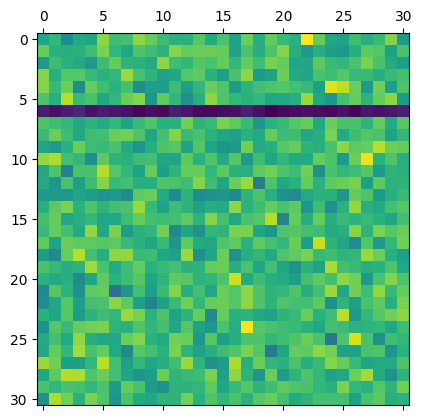

[[50. 56. 42. 52. 50. 69. 58. 59. 69. 64. 58. 54. 54. 62. 52. 60. 49. 65. 53. 64. 57. 54. 83. 64. 51. 49. 58. 53. 57. 68. 46.]
 [64. 54. 53. 54. 58. 67. 56. 51. 61. 58. 55. 68. 64. 65. 65. 64. 49. 60. 53. 61. 68. 53. 46. 53. 48. 46. 53. 63. 62. 48. 60.]
 [46. 58. 54. 52. 46. 58. 64. 55. 54. 52. 69. 58. 56. 62. 60. 64. 56. 64. 58. 67. 64. 50. 50. 63. 57. 56. 60. 67. 60. 52. 48.]
 [68. 53. 62. 62. 57. 54. 56. 71. 60. 55. 49. 51. 62. 63. 54. 48. 60. 69. 47. 49. 65. 52. 50. 60. 58. 62. 57. 57. 53. 57. 59.]
 [68. 57. 65. 42. 64. 58. 54. 59. 42. 48. 47. 58. 48. 56. 65. 61. 47. 55. 59. 61. 62. 59. 57. 48. 79. 75. 65. 46. 66. 48. 61.]
 [61. 53. 74. 57. 60. 51. 56. 65. 68. 45. 63. 56. 43. 53. 69. 61. 56. 54. 56. 50. 51. 53. 71. 51. 45. 59. 64. 55. 64. 69. 47.]
 [10.  7.  9. 12.  7.  9.  8.  7.  4.  6.  5. 10.  8.  5.  5.  6.  7. 11.  7.  3.  5.  6.  7.  6.  5.  7.  4.  8.  7.  8. 10.]
 [61. 58. 56. 51. 55. 52. 56. 49. 57. 61. 54. 54. 66. 55. 57. 67. 63. 57. 45. 54. 57. 62. 64. 51. 65. 60. 60. 5

In [3]:
model = benchmark(
    models.RandomClassifier(),
    "Random Classifier",
)
model.n_classes = len(mapping)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

#### 5.1.2. Transformer

Number of parameters: 481_311


100%|██████████| 975/975 [02:26<00:00,  6.63it/s]


1/20 Loss: 3352.55. F1: [0.18135, 0.0089326]. Patience: 3


100%|██████████| 975/975 [02:28<00:00,  6.56it/s]


2/20 Loss: 3350.83. F1: [0.18237, 0.0080511]. Patience: 2


100%|██████████| 975/975 [02:28<00:00,  6.57it/s]


3/20 Loss: 3349.84. F1: [0.13892, 0.0030442]. Patience: 1


100%|██████████| 975/975 [02:28<00:00,  6.55it/s]


4/20 Loss: 3348.67. F1: [0.063429, 0.0024861]. Patience: 0
The model is overfitting; stopping early.
Training took 663.401 s.


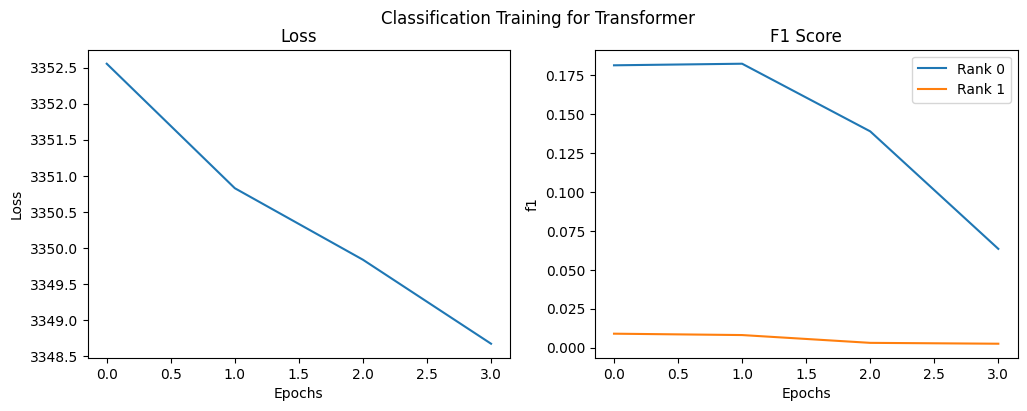

Test results: [0.063454, 0.0024411]


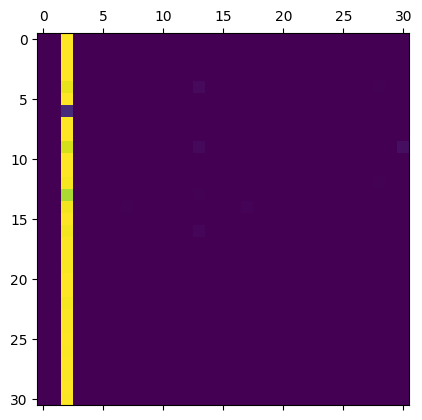

[[   0.    0. 1779.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.]
 [   0.    0. 1776.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.]
 [   0.    0. 1778.    0.    0.    0.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 1780.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 1724.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   44.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   10.    1.    0.]
 [   0.    0. 1775.    0.    0.    0.    0.    0.    0.

In [3]:
from torch import arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)


class T_2_tokens(Module):
    def __init__(self, N, M):
        super(T_2_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    transformer.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens, use_tokens=True),
    "Transformer",
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

#### 5.1.3 CNN

Number of parameters: 24_622_335


100%|██████████| 417/417 [00:11<00:00, 36.35it/s]


1/20 Loss: 1137.83. F1: [0.4247, 0.16016]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 36.83it/s]


2/20 Loss: 920.65. F1: [0.58881, 0.32773]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 36.38it/s]


3/20 Loss: 798.77. F1: [0.65082, 0.40633]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 35.74it/s]


4/20 Loss: 726.71. F1: [0.68036, 0.44117]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 35.71it/s]


5/20 Loss: 656.34. F1: [0.75924, 0.53038]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 35.80it/s]


6/20 Loss: 573.56. F1: [0.82977, 0.63383]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 36.40it/s]


7/20 Loss: 493.69. F1: [0.88302, 0.71909]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 36.17it/s]


8/20 Loss: 433.98. F1: [0.91558, 0.78847]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 36.01it/s]


9/20 Loss: 382.88. F1: [0.92352, 0.78872]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 36.07it/s]


10/20 Loss: 339.65. F1: [0.94387, 0.84507]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 36.23it/s]


11/20 Loss: 308.82. F1: [0.96411, 0.87512]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 36.20it/s]


12/20 Loss: 276.19. F1: [0.97004, 0.8904]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 36.05it/s]


13/20 Loss: 252.97. F1: [0.97738, 0.90919]. Patience: 3


100%|██████████| 417/417 [00:11<00:00, 36.08it/s]


14/20 Loss: 241.23. F1: [0.97259, 0.90912]. Patience: 2


100%|██████████| 417/417 [00:11<00:00, 36.26it/s]


15/20 Loss: 222.11. F1: [0.98251, 0.92279]. Patience: 2


100%|██████████| 417/417 [00:11<00:00, 36.17it/s]


16/20 Loss: 207.28. F1: [0.98562, 0.93276]. Patience: 2


100%|██████████| 417/417 [00:11<00:00, 36.08it/s]


17/20 Loss: 196.46. F1: [0.98228, 0.92558]. Patience: 1


100%|██████████| 417/417 [00:11<00:00, 35.74it/s]


18/20 Loss: 185.36. F1: [0.98709, 0.93668]. Patience: 1


100%|██████████| 417/417 [00:11<00:00, 35.98it/s]


19/20 Loss: 183.83. F1: [0.9904, 0.94426]. Patience: 1


100%|██████████| 417/417 [00:11<00:00, 36.11it/s]


20/20 Loss: 172.99. F1: [0.99236, 0.94936]. Patience: 1
Training took 346.730 s.


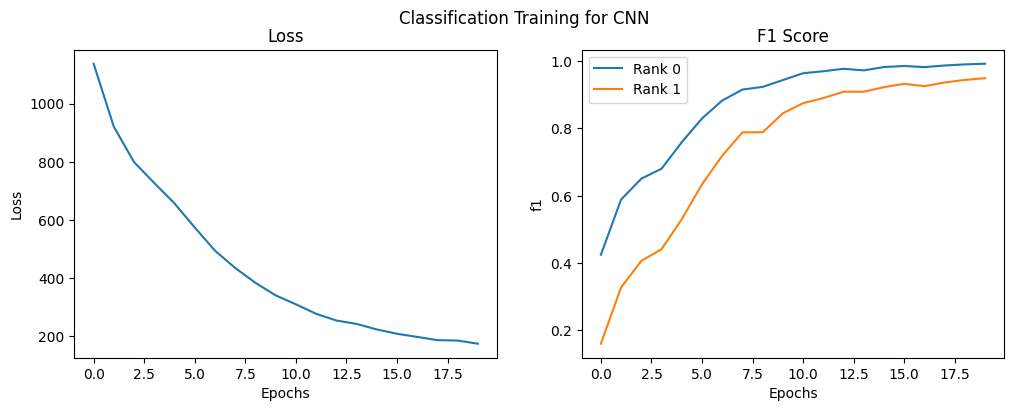

Test results: [0.99238, 0.94855]


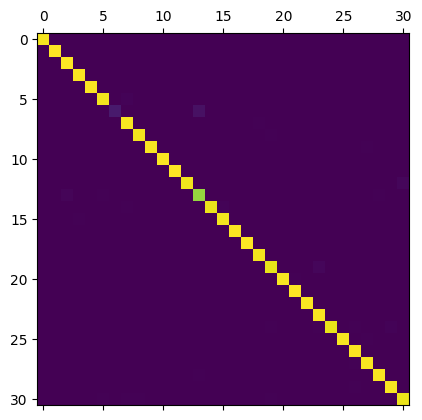

[[1758.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    4.    0.    1.    0.    0.    1.    4.    6.    0.    0.    1.    0.    1.    0.    0.    0.    0.    2.    0.    1.]
 [   0. 1774.    0.    0.    0.    0.    0.    0.    0.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    0.    2.    0.]
 [   0.    0. 1778.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    2. 1770.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    3.    1.    4.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1772.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    4.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    2.    0.    0. 1752.    0.   16.    0.

In [5]:
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d)
from torch import stack, tensor, float32, argmax
from torch.func import vmap
import torch.nn.functional as F


class CNN_2_dropout_token(Module):
    def __init__(self, N, M):
        super(CNN_2_dropout_token, self).__init__()
        self.conv = Sequential(
            Conv1d(4, 32, kernel_size=7, padding=3),
            ReLU(),
            Conv1d(32, 64, kernel_size=5, padding=2),
            ReLU(),
            Conv1d(64, 128, kernel_size=3, padding=1),
            ReLU(),
        )
        n = N * 4
        self.fc = Sequential(
            Flatten(),
            Dropout(0.2),
            Linear(n * 128, 128),
            ReLU(),
            Dropout(0.2),
            Linear(128, 64),
            ReLU(),
            Dropout(0.2),
            Linear(64, M)
        )

    def forward(self, x):
        B, N = x.shape
        shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
        x_expanded = x.unsqueeze(-1)
        tokens = (x_expanded >> shifts) & 0b11
        tokens = tokens.view(B, N * 4)
        one_hot = F.one_hot(tokens, num_classes=4).float()
        x = one_hot.permute(0, 2, 1)
        x = self.conv(x)
        x = self.fc(x)
        return x.float()


model = benchmark(
    feedforward.Classifier(LENGTH // 4, mapping, "cuda", CNN_2_dropout_token),
    "CNN",
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

#### 5.2. Data Validation

In [4]:
for x_batch, y_batch in test_data:
    x_batch = x_batch
    y_batch = y_batch.long()
    break

x = x_batch[0].tolist()
print(x)
s = synthetic.decode_tetramer(list(x))
print(s)
print(y_batch[0])

[250, 248, 79, 113, 255, 112, 134, 140, 58, 24, 117, 27, 236, 178, 251, 68, 240, 218, 0, 187, 116, 78, 192, 163, 192, 48, 128, 223, 112, 252, 239, 128, 205, 248, 252, 83, 197, 104, 242, 56, 7, 15, 2, 211, 242, 36, 58, 20, 7, 2, 179, 200, 189, 253, 195, 48, 196, 153, 64, 195, 216, 130, 160, 52, 193, 158, 249, 126, 175, 207, 226, 179, 160, 28, 248, 246, 9, 0, 207, 12, 168, 183, 243, 232, 160, 40, 160, 0, 114, 64, 58, 1, 0, 0, 145, 15, 227, 157, 32, 34, 77, 1, 244, 100, 56, 79, 188, 112, 75, 242, 10, 194, 72, 113, 224, 11, 241, 160, 33, 40, 27, 176, 8, 34, 125, 160, 136, 0, 56, 63, 40, 13, 225, 129, 123, 54, 188, 37, 246, 8, 0, 182, 8, 130, 194, 176, 32, 128, 51, 95, 97, 244, 184, 225, 142, 61, 224, 50, 139, 247, 252, 141, 130, 137, 19, 208, 2, 117, 34, 78, 48, 224, 2, 53, 30, 142, 47, 206, 27, 79, 130, 138, 32, 14, 44, 50, 192, 164, 236, 97, 34, 152, 79, 126, 59, 34, 141, 15, 191, 129, 250, 40, 22, 24, 226, 142, 248, 35, 12, 104, 195, 220, 51, 38, 0, 249, 192, 116, 9, 0, 1, 187, 2, 64, 2

In [15]:
predictions = model.model(x_batch.long().to("cuda"))
print(predictions[0])
print(argmax(predictions[0]))
print(argmax(predictions, dim=1))

tensor([ 0.0133, -0.4095, -0.8840, -0.0804, -0.1399, -0.3266, -0.8721, -3.5693,
         0.6553, -1.2975, -1.2246, -1.3659, -0.0511, -3.0972, -0.7880, -8.5872,
        -5.0709,  2.8188, -0.4040, -0.2330, -8.1135,  0.9699,  0.1175, -1.2901,
         0.0629, -2.9168, -2.0056, -1.1046, -0.5189, -0.6055, -0.4519],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(17, device='cuda:0')
tensor([17, 29, 29, 18, 26, 20, 25,  6,  8,  2,  6, 21, 17, 28, 14, 13,  7, 26,
        17,  8,  9, 20,  2, 16, 28, 21,  6, 26, 11,  8, 11, 26, 16, 17, 17, 25,
        29, 23, 10,  8, 15,  7, 26,  6, 28, 28,  6, 21,  9,  7,  6, 27, 21, 21,
        10,  2, 27, 15, 29, 15, 17,  8, 16, 18, 27,  6,  6, 26, 20, 27, 25,  8,
         6, 13,  6, 27, 17, 29, 28, 23, 14, 28, 10,  8, 28, 29, 17,  8, 27,  7,
        29,  7,  7,  8,  9, 27, 18,  2, 29, 20, 15, 29,  9,  7,  7, 21,  9,  8,
        26, 28,  2, 11,  6,  7, 18, 15, 23, 11, 28, 28, 28, 23,  7,  7, 20, 21,
        21, 17], device='cuda:0')


In [19]:
y = np.load(BERTAX_TRAIN + "y.npy")
unique_values, counts = np.unique(y, return_counts = True)
for v, c in zip(unique_values, counts):
    print(f"{v}: {c}")

0: 310423
1: 56878
2: 38004
3: 119750
4: 125620
5: 68062
6: 44260
7: 25192
8: 26154
9: 6573
10: 17510
11: 30286
12: 219383
13: 4025
14: 13440
15: 13243
16: 9548
17: 25574
18: 46804
19: 72703
20: 8627
21: 20200
22: 431030
23: 19783
24: 212677
25: 19670
26: 21213
27: 37889
28: 35408
29: 45429
30: 55702


#### 5.1.4 Autoencoder

Number of parameters: 73_427_773


100%|██████████| 975/975 [00:35<00:00, 27.52it/s]


1/20 Loss: 983.18. F1: [0.1048, 0.002068]. Patience: 3


100%|██████████| 975/975 [00:34<00:00, 28.14it/s]


2/20 Loss: 974.07. F1: [0.14259, 0.0020685]. Patience: 3


100%|██████████| 975/975 [00:35<00:00, 27.54it/s]


3/20 Loss: 974.04. F1: [0.058548, 0.0020677]. Patience: 2


100%|██████████| 975/975 [00:35<00:00, 27.48it/s]


4/20 Loss: 973.99. F1: [0.12272, 0.0043195]. Patience: 2


100%|██████████| 975/975 [00:35<00:00, 27.39it/s]


5/20 Loss: 973.87. F1: [0.13738, 0.0077148]. Patience: 2


100%|██████████| 975/975 [00:35<00:00, 27.16it/s]


6/20 Loss: 971.37. F1: [0.23701, 0.021236]. Patience: 2


100%|██████████| 975/975 [00:36<00:00, 27.08it/s]


7/20 Loss: 953.00. F1: [0.24523, 0.022595]. Patience: 2


100%|██████████| 975/975 [00:36<00:00, 26.51it/s]


8/20 Loss: 866.77. F1: [0.2432, 0.027177]. Patience: 2


100%|██████████| 975/975 [00:36<00:00, 26.97it/s]


9/20 Loss: 592.08. F1: [0.24017, 0.025884]. Patience: 1


100%|██████████| 975/975 [00:35<00:00, 27.20it/s]


10/20 Loss: 317.26. F1: [0.24501, 0.024869]. Patience: 0
The model is overfitting; stopping early.
Training took 409.786 s.


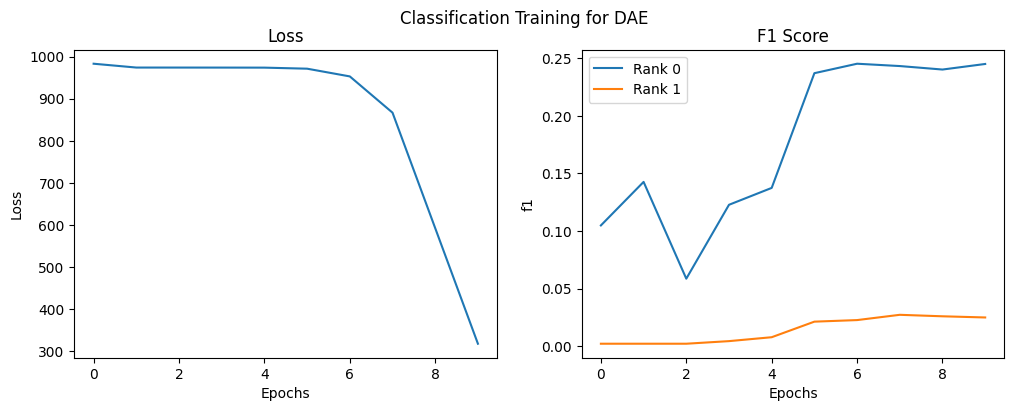

Test results: [0.24517, 0.024549]


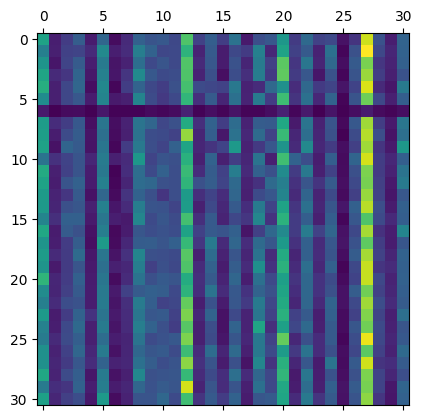

[[123.  18.  38.  63.  16.  70.   7.  25.  66.  55.  59.  46. 154.  42.  64.  39.  80.  15.  51.  58. 113.  37.  73.  42.  47.  10.  32. 197.  54.  18.  68.]
 [ 92.  19.  41.  44.  25. 100.  18.  27.  91.  67.  45.  47. 138.  21.  60.  16.  46.  37.  93.  24. 123.  41.  60.  20.  79.   4.  53. 213.  46.  23.  67.]
 [110.  13.  44.  61.  18.  87.  12.  20.  77.  47.  56.  47. 155.  25.  58.  16.  54.  22.  89.  40. 159.  34.  84.  22.  72.   8.  60. 170.  34.  21.  65.]
 [124.  25.  34.  69.  14.  93.  13.  33. 102.  59.  48.  50. 154.  21.  52.   9.  50.  29.  90.  36. 161.  37.  58.  13.  54.   4.  55. 181.  39.  19.  54.]
 [133.  19.  45.  70.   8.  99.   4.  39.  68.  46.  39.  53. 150.  49.  45.  42.  85.  20.  26.  72. 107.  27.  72.  36.  44.  12.  43. 201.  25.  13.  88.]
 [104.  19.  45.  58.  16.  96.  15.  19.  96.  49.  35.  47. 140.  29.  61.  22.  79.  21.  88.  38. 147.  32.  79.  24.  68.   3.  55. 166.  46.  19.  64.]
 [ 15.   1.   6.   7.   1.  14.   2.   2.   2.   6. 

In [3]:
from torch import clamp, tensor
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d, LeakyReLU, ConvTranspose1d, Sigmoid)
from torch import stack, tensor, float32
from torch.func import vmap
import torch.nn.functional as F


class Unsqueeze(Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x.unsqueeze(self.dim)


class DAE_1(Module):
    """Denoising autoencoder 1."""
    def __init__(self, N, M):
        super(DAE_1, self).__init__()
        LATENT_SPACE_SIZE = 128
        N *= 4
        self.encoder = Sequential(
            Conv1d(4, 32, kernel_size=5, padding=2),
            LeakyReLU(),
            MaxPool1d(kernel_size=2),
            Conv1d(32, 64, kernel_size=3, padding=1),
            LeakyReLU(),
            Flatten(),
            Linear(N * 64 // 2, N),
            LeakyReLU(),
            Linear(N, LATENT_SPACE_SIZE),
            LeakyReLU(),
        )
        self.decoder = Sequential(
            Linear(LATENT_SPACE_SIZE, N // 2),
            LeakyReLU(),
            Linear(N // 2, N),
            LeakyReLU(),
            Unsqueeze(1),
            ConvTranspose1d(1, 4, kernel_size=3, stride=1, padding=1),
            LeakyReLU(),
            Sigmoid(),
        )
        self.classifier = Linear(LATENT_SPACE_SIZE, M)

    def forward(self, x):
        if self.training:
            B, N = x.shape
            shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
            x_expanded = x.unsqueeze(-1).to(int)
            tokens = (x_expanded >> shifts) & 0b11
            tokens = tokens.view(B, N * 4)
            one_hot = F.one_hot(tokens, num_classes=4).float()
            x = one_hot.permute(0, 2, 1)
            x_noisy = autoencoder.add_masking_noise(x, dropout_prob=0.2)
            x_noisy = clamp(x_noisy, 0.0, 1.0)
            latent = self.encoder(x_noisy)
        else:
            B, N = x.shape
            shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
            x_expanded = x.unsqueeze(-1).to(int)
            tokens = (x_expanded >> shifts) & 0b11
            tokens = tokens.view(B, N * 4)
            one_hot = F.one_hot(tokens, num_classes=4).float()
            x = one_hot.permute(0, 2, 1)
            latent = self.encoder(x)
        classification = self.classifier(latent)
        reconstruction = self.decoder(latent)
        return classification, reconstruction


model = benchmark(
    autoencoder.Classifier(LENGTH // 4, mapping, "cuda", DAE_1),
    "DAE",
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

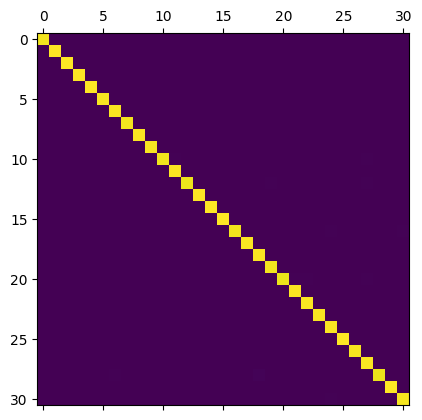

[[3938.    0.    1.    1.    0.    8.    0.    1.    5.    1.    2.    1.    8.    0.   11.    0.    1.    3.    9.   12.    6.    1.    1.    2.    8.    0.    0.    4.    1.    0.    0.]
 [   0. 4009.    1.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    2.    2.    0.    0.    4.    0.    2.    0.    0.    0.    0.    0.    2.    0.    0.    0.    2.]
 [   0.    1. 4012.    0.    0.    0.    0.    0.    0.    0.    2.    0.    1.    0.    1.    0.    1.    0.    0.    0.    6.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.]
 [   0.    1.    0. 4001.    0.    4.    0.    0.    1.    0.    0.    0.    1.    0.    2.    0.    0.    0.    0.    0.    0.    5.    7.    0.    0.    0.    0.    0.    0.    1.    2.]
 [   0.    0.    0.    1. 4002.    0.    4.    1.    0.    1.    1.    3.    0.    0.    0.    0.    0.    0.    0.    0.    2.    0.    0.    3.    2.    0.    0.    0.    1.    3.    1.]
 [   7.    0.    0.   12.    0. 3979.    0.    0.    0.

In [4]:
matrix = confusion_matrix(model, train_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

### 5.3. Test

In [4]:
BERTAX_DIRECTORY = DATA_DIRECTORY + "bertax/non_similar/"
BERTAX_TRAIN = BERTAX_DIRECTORY + "train/"
BERTAX_TEST = BERTAX_DIRECTORY + "test/"
BERTAX_RAW_DATA = BERTAX_DIRECTORY + "non_similar_dataset/"

from stelaro import models
import numpy as np
from torch import tensor
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import bincount
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from stelaro.models import feedforward, autoencoder, transformer, hybrid
from time import time
from random import shuffle

LENGTH = 1500
BATCH_SIZE = 256


# N = len(np.load(BERTAX_TRAIN + "y.npy"))
# indices = list(range(N))
# shuffle(indices)
# train_indices = indices[0:250_000]
# test_indices = indices[250_000:300_000]

DATASET = BERTAX_TRAIN
y = np.load(DATASET + "y.npy")
unique_values, counts = np.unique(y, return_counts = True)
n = min(counts) * 6
indices = list(range(len(y)))
amounts = {}
for v in unique_values:
    amounts[int(v)] = 0
balanced_indices = []
for index in indices:
    label = int(y[index])
    if amounts[label] < n:
        balanced_indices.append(index)
        amounts[label] += 1

# labels = np.zeros(len(balanced_indices))
# for i, index in enumerate(balanced_indices):
#     labels[i] = y[index]
# unique_values, counts = np.unique(labels, return_counts=True)
# for v, c in zip(unique_values, counts):
#     print(f"{v}: {c}")

shuffle(balanced_indices)
cutoff = int(len(balanced_indices) * 0.9)
train_indices = balanced_indices[:cutoff]
test_indices = balanced_indices[cutoff:]

train_data = DataLoader(
    models.SyntheticTetramerDataset_2(DATASET, indices=train_indices),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_data = DataLoader(
    models.SyntheticTetramerDataset_2(DATASET, indices=test_indices),
    batch_size=BATCH_SIZE,
    shuffle=True
)

with open(BERTAX_DIRECTORY + "map.json", "r") as f:
    mapping = json.load(f)


def benchmark(classifier: models.BaseClassifier, name: str):
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=0.001)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1 = classifier.train(
        train_data,
        test_data,
        optimizer,
        max_n_epochs=20,
        patience=3,
        permute=False
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="losses")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Loss")
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping, permute=False)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test results: {rounded_result}")
    return classifier


from torch import no_grad, float32
import numpy as np


def confusion_matrix(classifier, loader, device, mapping) -> np.ndarray:
    """Returns: A confusion matrix with rows corresponding to true labels."""
    matrix = np.zeros((len(mapping), len(mapping)))
    with no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.long().to(device)
            #x_batch = x_batch.permute(0, 2, 1)  # Swap channels and sequence.
            y_batch = y_batch.to("cpu")
            predictions = classifier.predict(x_batch)
            for y, p in zip(y_batch, predictions):
                matrix[y][p] += 1
    return matrix

In [6]:
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d)
from torch import stack, tensor, float32, argmax
from torch.func import vmap
import torch.nn.functional as F


class CNN_2_dropout_token(Module):
    def __init__(self, N, M):
        super(CNN_2_dropout_token, self).__init__()
        self.conv = Sequential(
            Conv1d(4, 32, kernel_size=7, padding=3),
            ReLU(),
            Conv1d(32, 64, kernel_size=5, padding=2),
            ReLU(),
            Conv1d(64, 128, kernel_size=3, padding=1),
            ReLU(),
        )
        n = N * 4
        self.fc = Sequential(
            Flatten(),
            Dropout(0.2),
            Linear(n * 128, 128),
            ReLU(),
            Dropout(0.2),
            Linear(128, 64),
            ReLU(),
            Dropout(0.2),
            Linear(64, M)
        )

    def forward(self, x):
        B, N = x.shape
        shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
        x_expanded = x.unsqueeze(-1)
        tokens = (x_expanded >> shifts) & 0b11
        tokens = tokens.view(B, N * 4)
        one_hot = F.one_hot(tokens, num_classes=4).float()
        x = one_hot.permute(0, 2, 1)
        x = self.conv(x)
        x = self.fc(x)
        return x.float()


from torch import arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)


class T_2_tokens(Module):
    def __init__(self, N, M):
        super(T_2_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=4,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=8)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    feedforward.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens),
    "CNN",
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

Number of parameters: 1_670_943


  0%|          | 2/2239 [00:11<3:30:59,  5.66s/it]


KeyboardInterrupt: 